# 診察結果画像の視線注目箇所分布導出

# 11月15日の作業内容記載

## ライブラリのインポート

In [1]:
import IPython.display as ipd
import pandas as pd
from scipy.io import wavfile
import os
import numpy as np
from scipy import signal
from hmmlearn import hmm
from scipy import fftpack
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import librosa
import librosa.display 
import cv2
from sklearn.preprocessing import StandardScaler
#import matwavlib as mw

import warnings
warnings.simplefilter('ignore')

### 音声ファイルの確認

In [2]:
path = "csv/"
csv_files = os.listdir(path)
csv_files = sorted(csv_files)
csv_files.remove('.DS_Store')
print('----')
print(csv_files)

----
['asada_pupil_data_1.csv', 'asada_pupil_data_2.csv', 'asada_pupil_data_3.csv', 'harada_pupil_data_1.csv', 'harada_pupil_data_2.csv', 'harada_pupil_data_3.csv', 'shiono_pupil_data_1.csv', 'shiono_pupil_data_2.csv', 'shiono_pupil_data_3.csv']


## 生成する画像のファイル名の一部を定義
画像保存、読み取りの際に利用

In [3]:
sub_num = 0
data_num = 4
sub_spec = csv_files[sub_num]
sub_plot = csv_files[sub_num+1]
sub_anime = csv_files[sub_num+2]

## 音声ファイル読み込み

In [4]:
df_sub_spec = pd.read_csv(path+sub_spec)
df_sub_plot = pd.read_csv(path+sub_plot)
df_sub_anime = pd.read_csv(path+sub_anime)
print("total_time : "+str((len(df_sub_spec))/60.0)+"seconds")
df_sub_spec

total_time : 196.45seconds


,L_pupil,R_pupil,L_gaze,R_gaze
0,NaN,NaN,"(nan, nan)","(nan, nan)"
1,NaN,NaN,"(nan, nan)","(nan, nan)"
2,NaN,NaN,"(nan, nan)","(nan, nan)"
3,NaN,NaN,"(nan, nan)","(nan, nan)"
4,NaN,NaN,"(nan, nan)","(nan, nan)"
...,...,...,...,...
11782,NaN,NaN,"(nan, nan)","(nan, nan)"
11783,NaN,NaN,"(nan, nan)","(nan, nan)"
11784,NaN,NaN,"(nan, nan)","(nan, nan)"
11785,NaN,NaN,"(nan, nan)","(nan, nan)"


In [5]:
def get_data(df_sub):
    
    #col = ["pupil_L","pupil_R","gaze_L","gaze","","",""]
    df_eye = pd.DataFrame(index=[],columns=[])
    
    time_array = np.array([])
    period_sub = ((len(df_sub))/60.0)/len(df_sub)
    
    for i in range(len(df_sub)):
        time_array = np.append(time_array, period_sub*i)
    print(len(time_array))
        
    #-------------------------------------------------------------------------------#
    
    sub_array = np.array([])
    sub_str = df_sub.iloc[:,0]
    pupil = sub_str.fillna(100000)
    sub_Lpupil = np.array(pupil)
    print(len(sub_Lpupil))
    
    #-------------------------------------------------------------------------------#
    
    sub_array = np.array([])
    sub_str = df_sub.iloc[:,1]
    pupil = sub_str.fillna(100000)
    sub_Rpupil = np.array(pupil)

    #-------------------------------------------------------------------------------#
    sub_array = np.array([])
    sub_str = df_sub.iloc[:,2]

    for str_num in sub_str:

        if str_num[1]=='n':
            #sub_array = np.append(sub_array, (float('nan'),float('nan')))
            sub_array = np.append(sub_array, (0,0))
        else:
            sub_array = np.append(sub_array, eval(str_num))
            


    sub_Lgaze_array_x = sub_array[0::2]
    sub_Lgaze_array_y = sub_array[1::2]

    #-------------------------------------------------------------------------------#

    sub_array = np.array([])
    sub_str = df_sub.iloc[:,3]

    for str_num in sub_str:
        
        if str_num[1]=='n':
            #sub_array = np.append(sub_array, (float('nan'),float('nan')))
            sub_array = np.append(sub_array, (0,0))
        else:
            sub_array = np.append(sub_array, eval(str_num))

    sub_Rgaze_array_x = sub_array[0::2]
    sub_Rgaze_array_y = sub_array[1::2]
    
    #-------------------------------------------------------------------------------#
    
    df_eye["time"]=time_array
    df_eye["Lpupil"]=sub_Lpupil
    df_eye["Rpupil"]=sub_Rpupil
    df_eye["LgazeX"]=sub_Lgaze_array_x
    df_eye["LgazeY"]=sub_Lgaze_array_y
    df_eye["RgazeX"]=sub_Rgaze_array_x
    df_eye["RgazeY"]=sub_Rgaze_array_y
    
    
    print(len(time_array))
    print(len(sub_Lpupil))
    print(len(sub_Rpupil))
    print(len(sub_Lgaze_array_x))
    print(len(sub_Lgaze_array_y))
    print(len(sub_Rgaze_array_x))
    print(len(sub_Rgaze_array_y))

    return df_eye

In [6]:
df_eye = get_data(df_sub_spec) 
df_eye_plot = get_data(df_sub_plot)
df_eye_anime = get_data(df_sub_anime)

11787
11787
11787
11787
11787
11787
11787
11787
11787
9301
9301
9301
9301
9301
9301
9301
9301
9301
10237
10237
10237
10237
10237
10237
10237
10237
10237


## 11/15
## 最適診断結果画像の調査実験により取得した視線データの検出プログラムeye_research.ipynbの制作


診察画像に対して医師がどのように説明するべきか、どのように画像を提示するべきかを調査する  
画像を見ている被験者の目線の位置を特定するためにTobii eye trackerを使用する  
現在プログラムを作成中


In [7]:
df_eye_inter = df_eye.interpolate(limit_direction='both')
df_eye_inter_plot = df_eye_plot.interpolate(limit_direction='both')
df_eye_inter_anime = df_eye_anime.interpolate(limit_direction='both')

In [8]:
def range_adj(df_inter):
    df_inter['LgazeX'].where((df_inter['LgazeX'] >= 0.0), 0.0, inplace=True)
    df_inter['LgazeX'].where((df_inter['LgazeX'] <= 1.0), 1.0, inplace=True)

    df_inter['LgazeY'].where((df_inter['LgazeY'] >= 0.0), 0.0, inplace=True)
    df_inter['LgazeY'].where((df_inter['LgazeY'] <= 1.0), 1.0, inplace=True)

    df_inter['RgazeX'].where((df_inter['RgazeX'] >= 0.0), 0.0, inplace=True)
    df_inter['RgazeX'].where((df_inter['RgazeX'] <= 1.0), 1.0, inplace=True)

    df_inter['RgazeY'].where((df_inter['RgazeY'] >= 0.0), 0.0, inplace=True)
    df_inter['RgazeY'].where((df_inter['RgazeY'] <= 1.0), 1.0, inplace=True)
    
    return df_inter

In [9]:
df_eye_inter = range_adj(df_inter=df_eye_inter)
df_eye_inter_plot = range_adj(df_inter=df_eye_inter_plot)
df_eye_inter_anime = range_adj(df_inter=df_eye_inter_anime)

In [10]:
df_eye_inter_anime

,time,Lpupil,Rpupil,LgazeX,LgazeY,RgazeX,RgazeY
0,0.000000,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
1,0.016667,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
2,0.033333,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
3,0.050000,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
4,0.066667,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
10232,170.533333,2.652985,2.739609,0.551444,0.565623,0.556209,0.729609
10233,170.550000,2.593231,2.762573,0.542900,0.515563,0.553273,0.742986
10234,170.566667,2.584198,2.818893,0.545499,0.534013,0.538771,0.773013
10235,170.583333,2.618942,2.838898,0.551311,0.569869,0.546152,0.783850


In [11]:
x_size = 1366
y_size = 768
screen_x = np.linspace(40.0, 1180, 10000)
z_max = np.linspace(504, 504, 10000)
z_min = np.linspace(256, 256, 10000)

screen_y = np.linspace(256, 504, 10000)
x_max = np.linspace(1180, 1180, 10000)
x_min = np.linspace(40, 40, 10000)

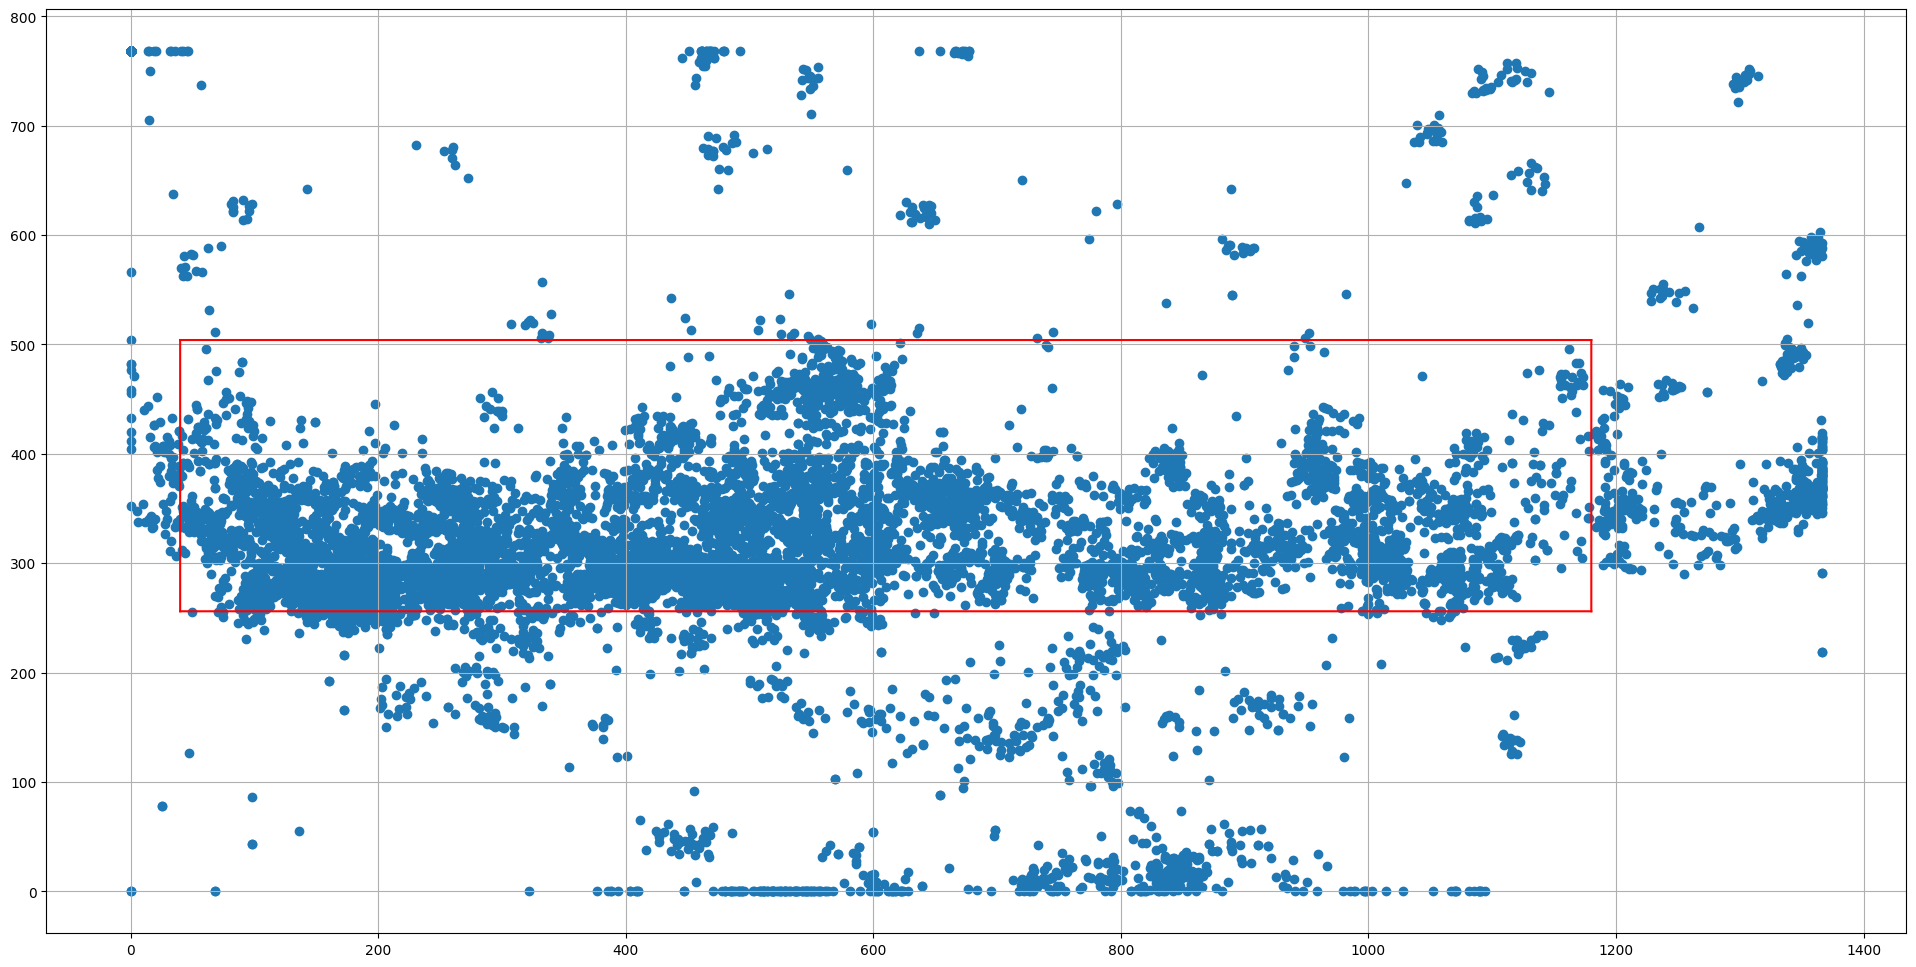

In [12]:
plt.figure(figsize=(24,12))
plt.grid()
plt.scatter(df_eye_inter["LgazeX"]*x_size, (df_eye_inter["LgazeY"]-1)*-y_size)
plt.plot(screen_x, z_max ,color = "red")
plt.plot(screen_x, z_min ,color = "red")
plt.plot(x_max, screen_y ,color = "red")
plt.plot(x_min, screen_y ,color = "red")
#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
#plt.legend(loc="lower right")
#plt.xticks(np.arange(0, 15.0, 0.5))
plt.show()

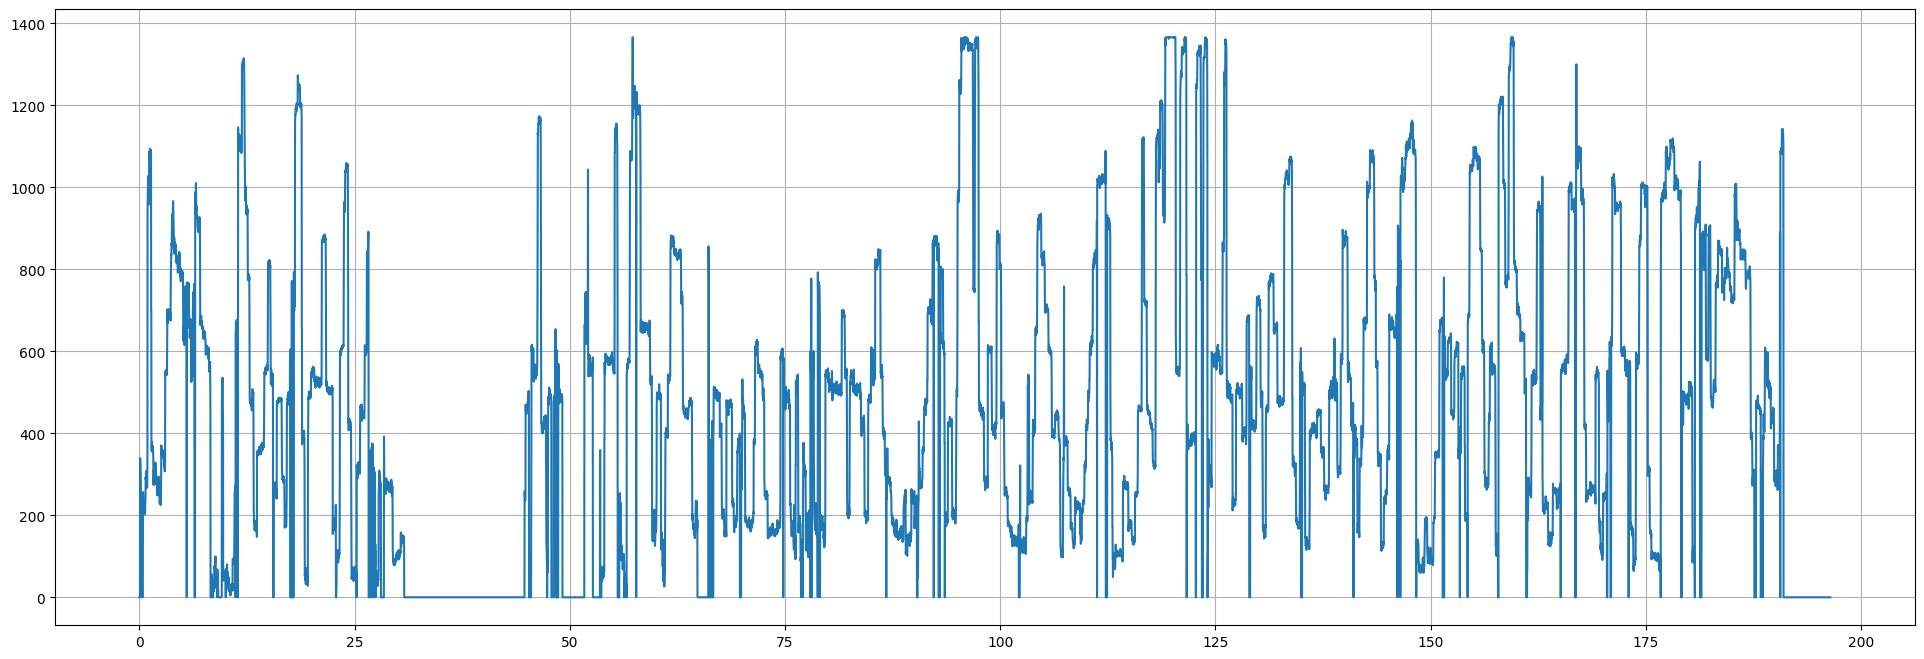

In [13]:
plt.figure(figsize=(24,8))
plt.grid()
plt.plot(df_eye_inter["time"], df_eye_inter["LgazeX"]*x_size)
#plt.legend(loc="lower right")
#plt.xticks(np.arange(0, 15.0, 0.5))
plt.show()

# Spectrogram個別分析

## データ収集開始35 秒　　動画42秒から対象　42秒
## Aさん・6秒後に提示開始、10秒目から説明開始　97秒目まで健常者1の説明
## Aさん・98秒後に提示開始、100秒目から説明開始　117秒目まで健常者2の説明
## Aさん・127秒後に提示開始、130秒目から説明開始　160秒目まで間質性肺炎患者1の説明
## Aさん・161秒後に提示開始、162秒目から説明開始　185秒目まで間質性肺炎患者2の説明


In [14]:
start_time = [6.0,98.0,127.0,161.0]
explain_time = [10.0,100.0,130.0,162.0]
end_time = [97.0,117.0,160.0,185.0]

# Lgaze

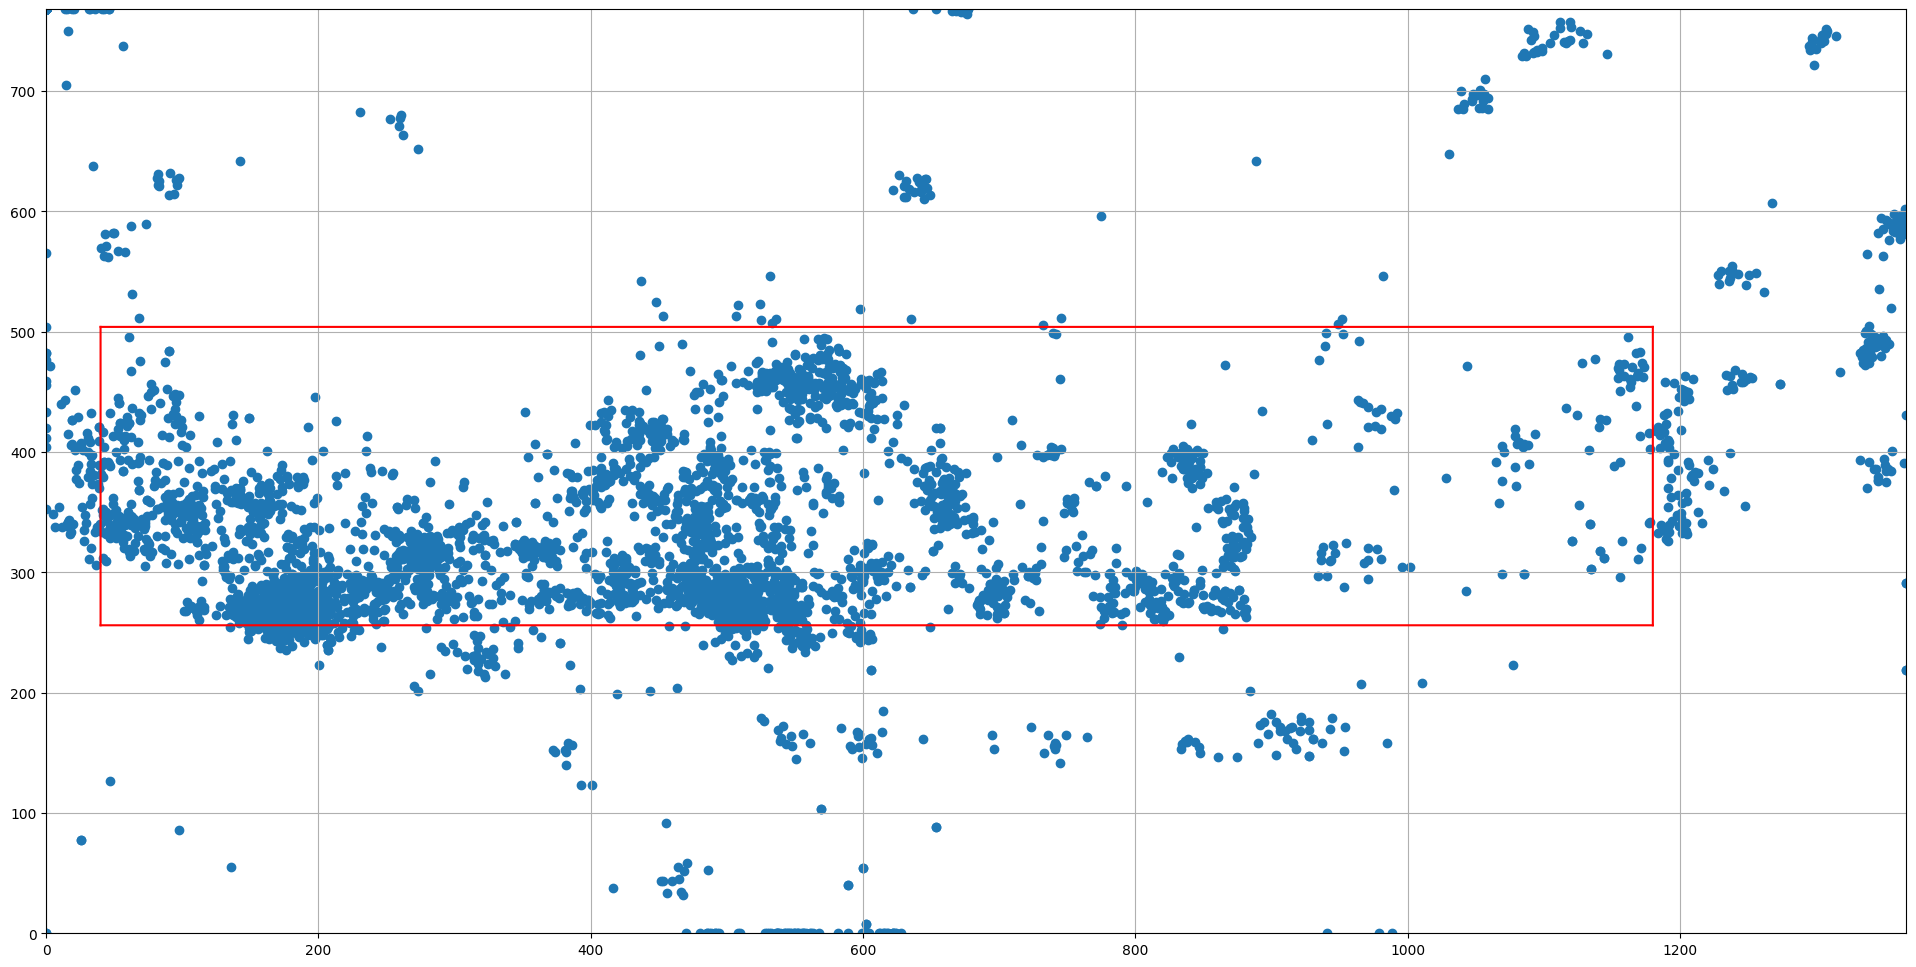

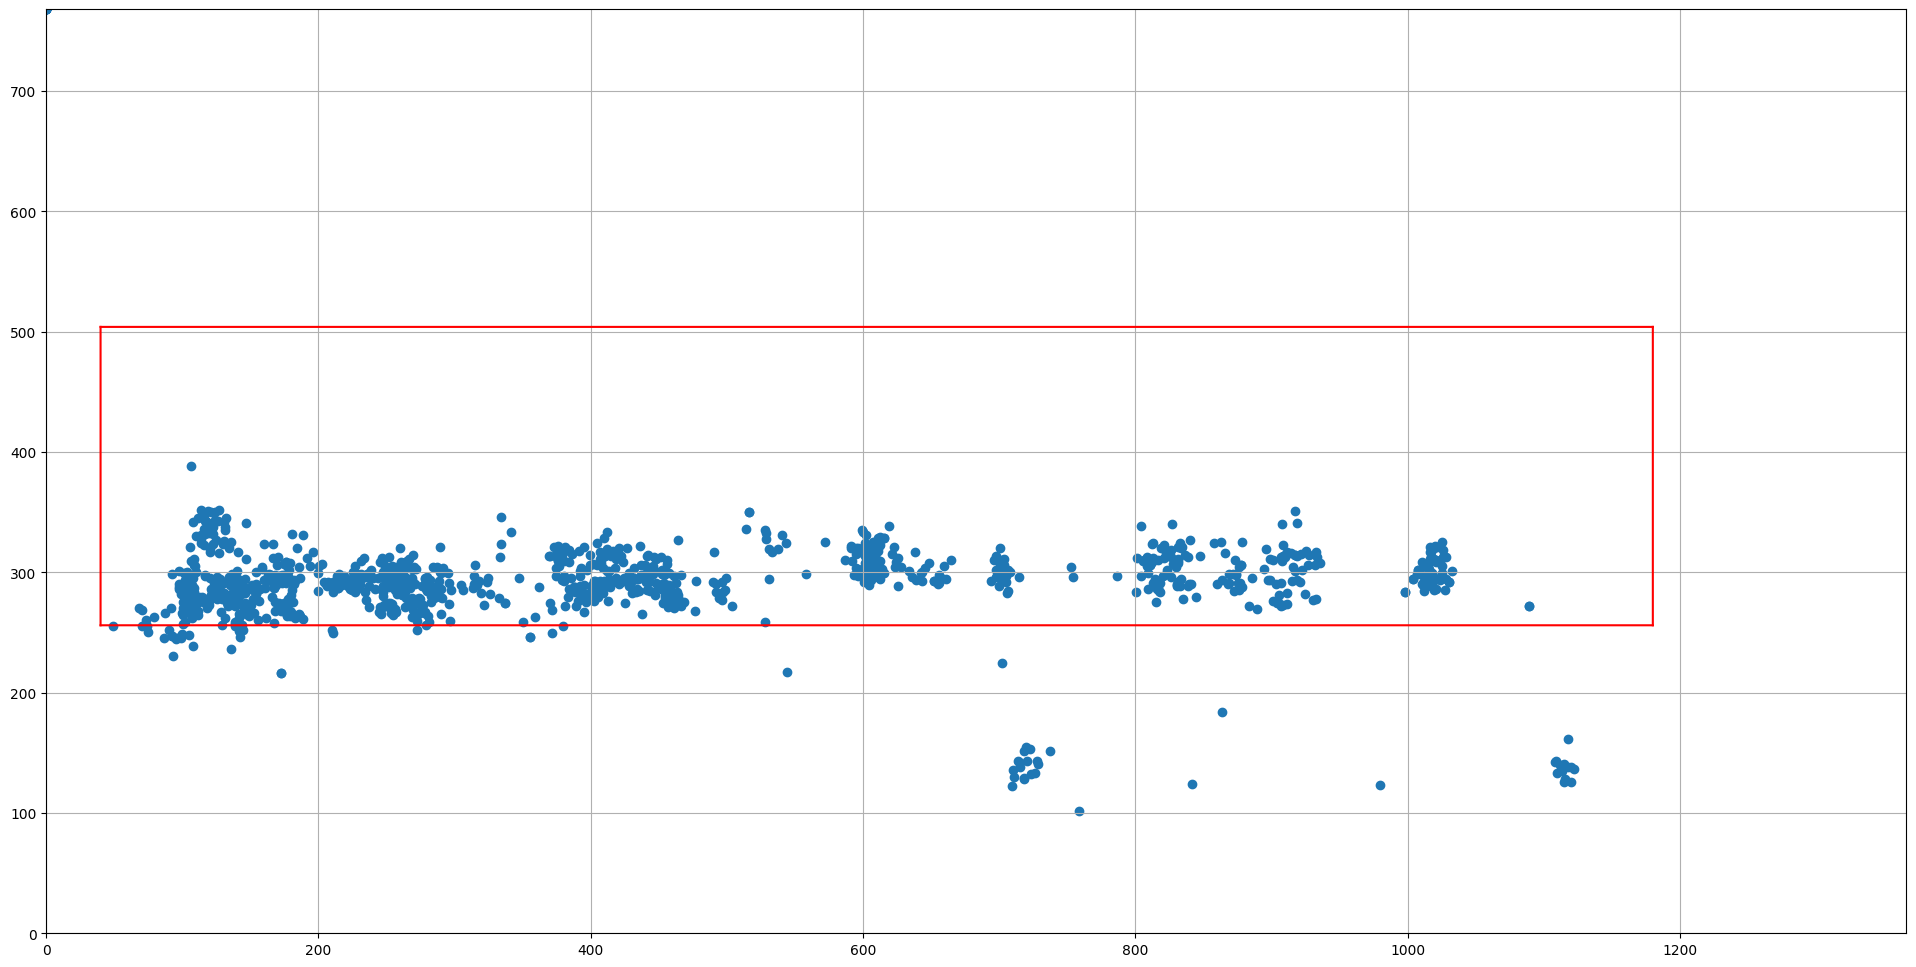

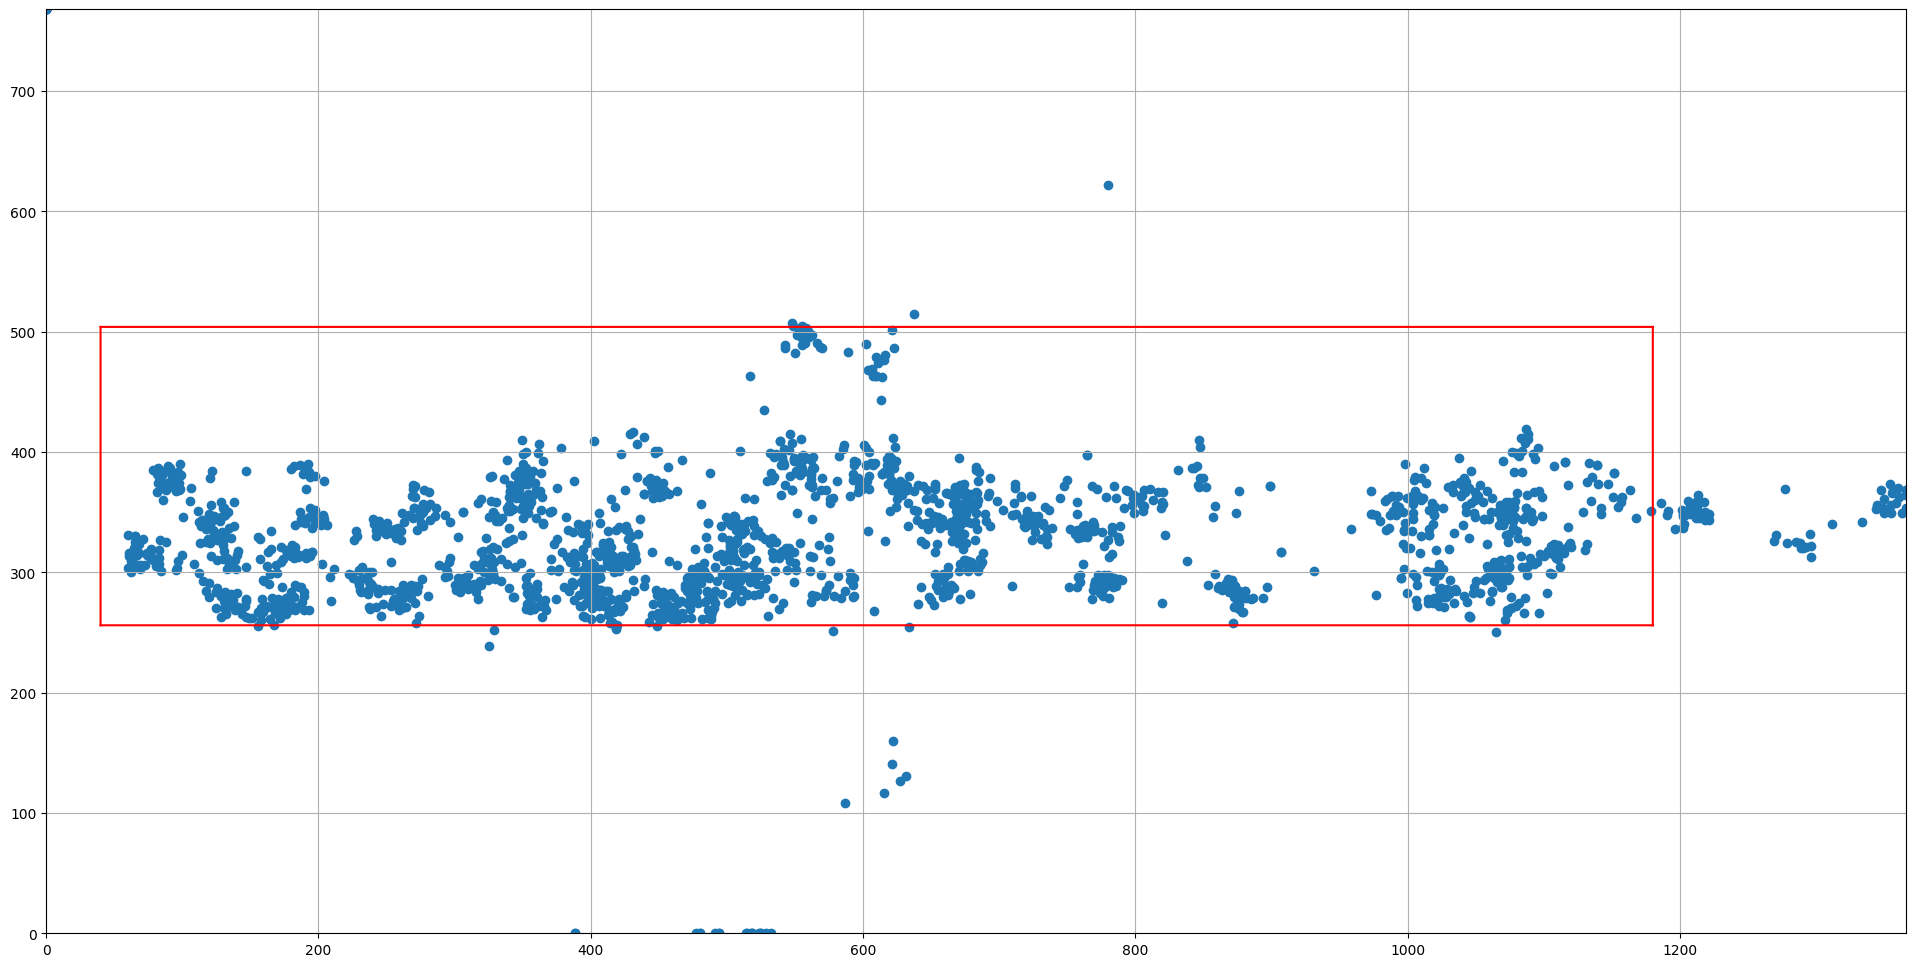

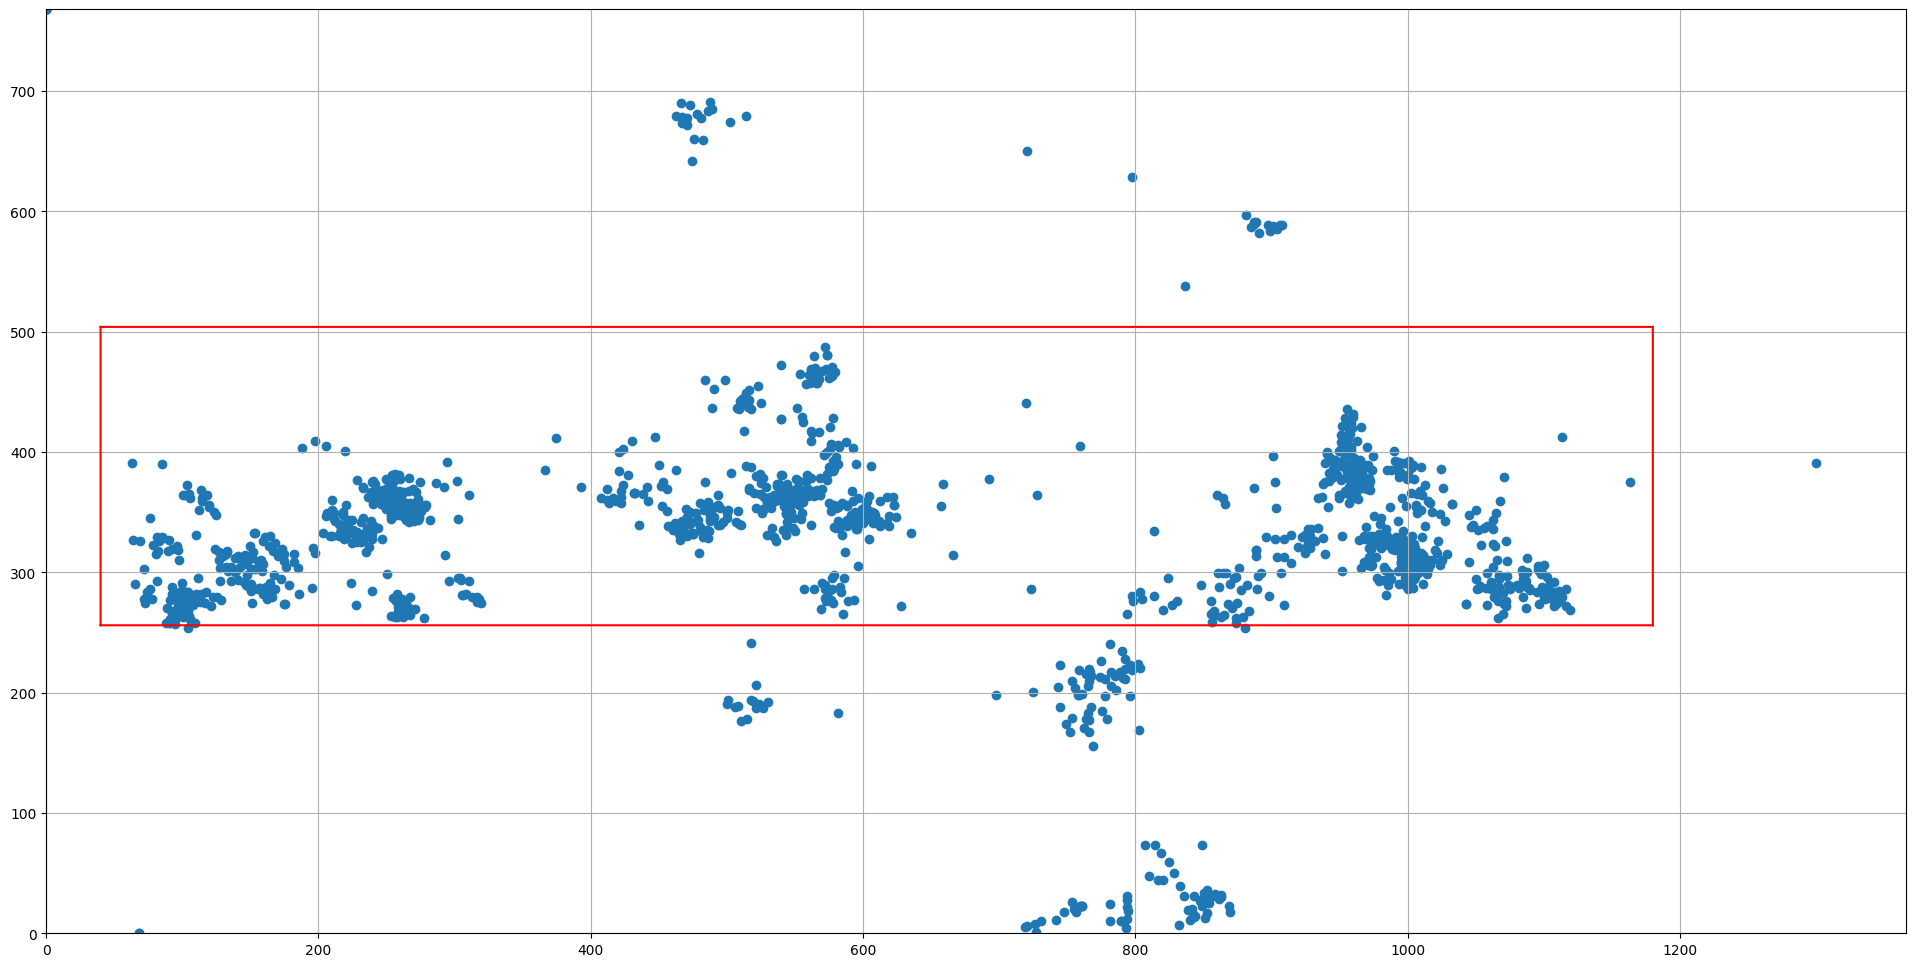

In [15]:
for im_num in range(data_num):
    plt.figure(figsize=(24, 12))
    plt.grid()
    plt.scatter(df_eye_inter[(df_eye_inter["time"]>=start_time[im_num]) & (df_eye_inter["time"]<=end_time[im_num])]["LgazeX"]*x_size,  ((df_eye_inter[(df_eye_inter["time"]>=start_time[im_num]) & (df_eye_inter["time"]<=end_time[im_num])]["LgazeY"])-1)*-y_size)
    plt.plot(screen_x, z_max ,color = "red")
    plt.plot(screen_x, z_min ,color = "red")
    plt.plot(x_max, screen_y ,color = "red")
    plt.plot(x_min, screen_y ,color = "red")
    plt.xlim(0, x_size)
    plt.ylim(0, y_size)
    plt.show()

初めて見るものに対してのバイアス

# Rgaze

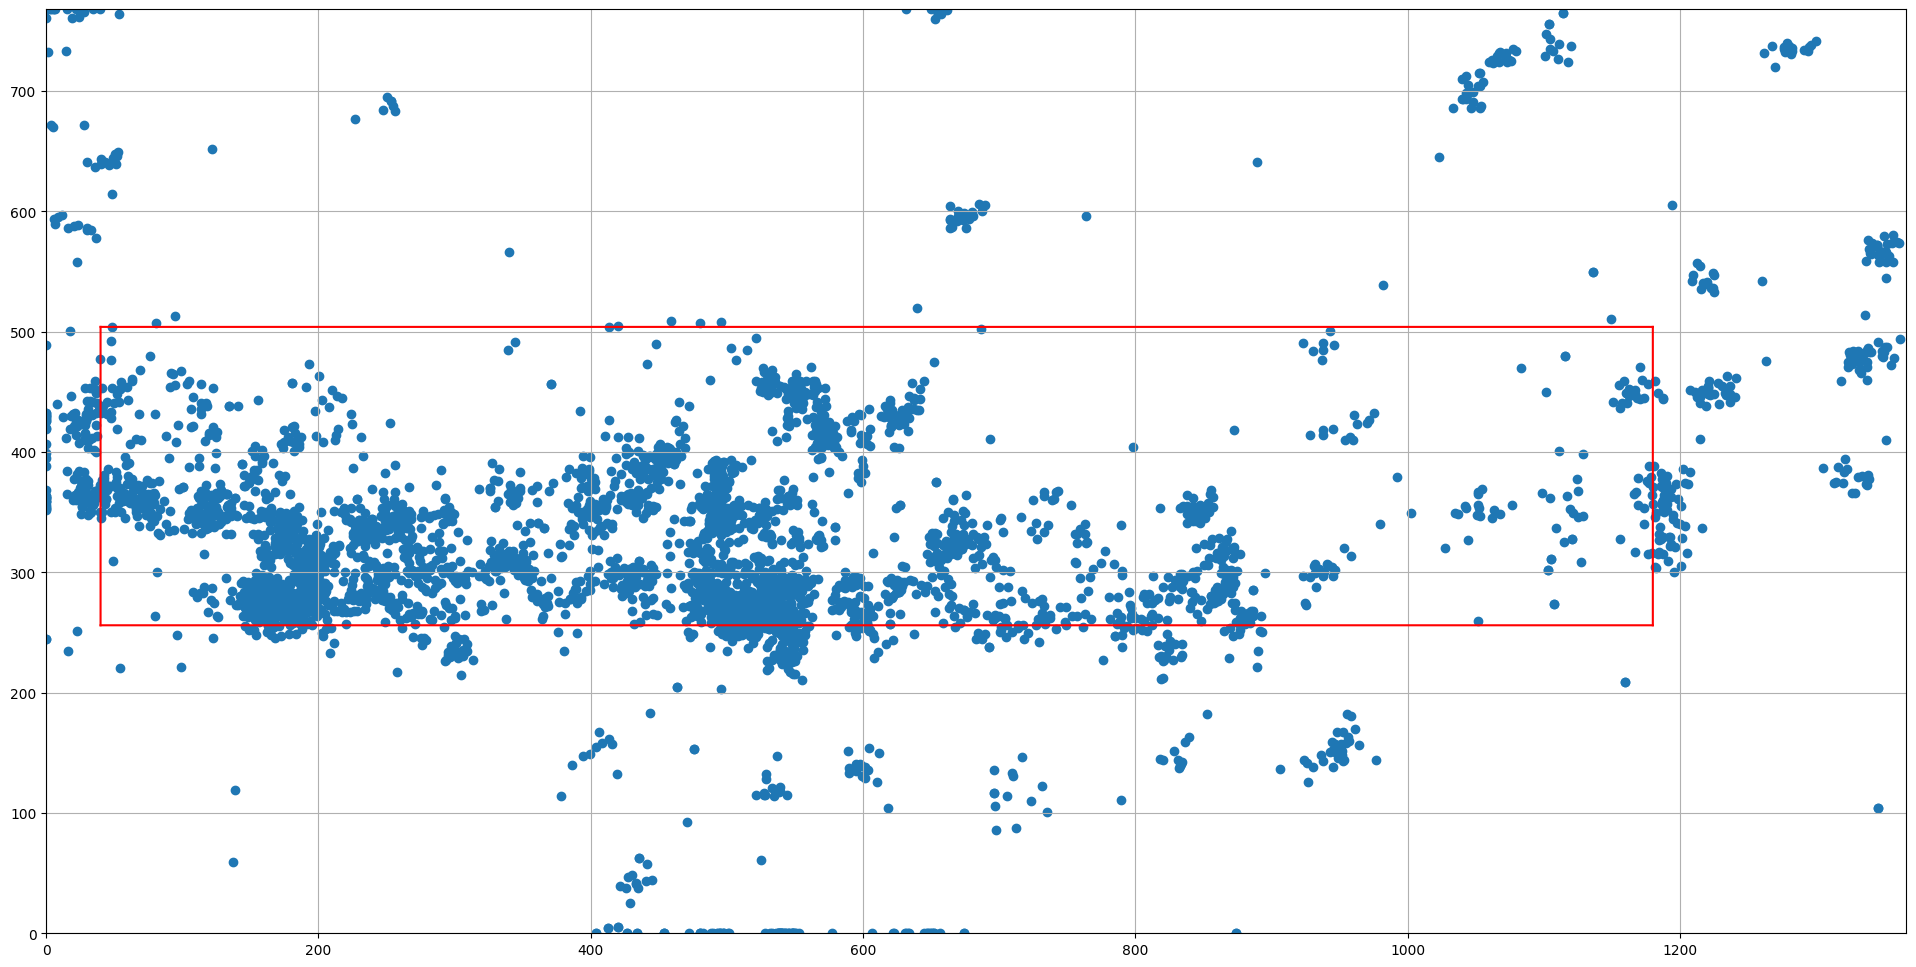

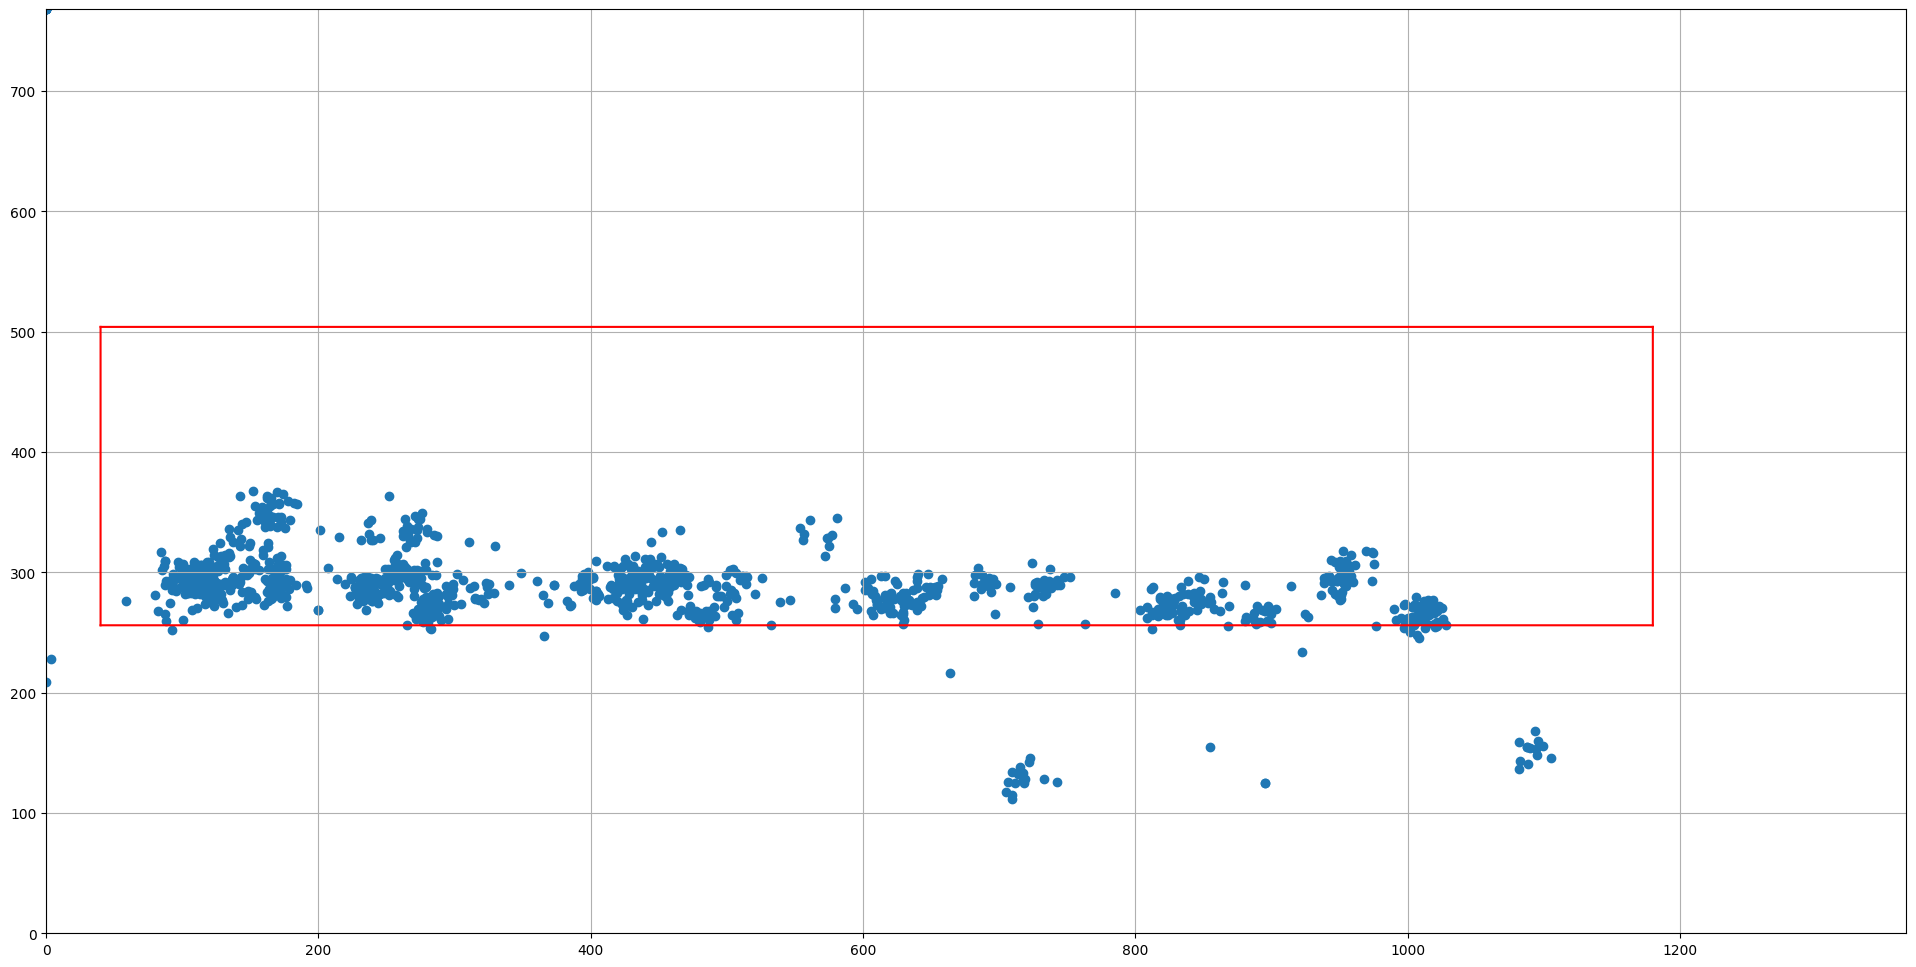

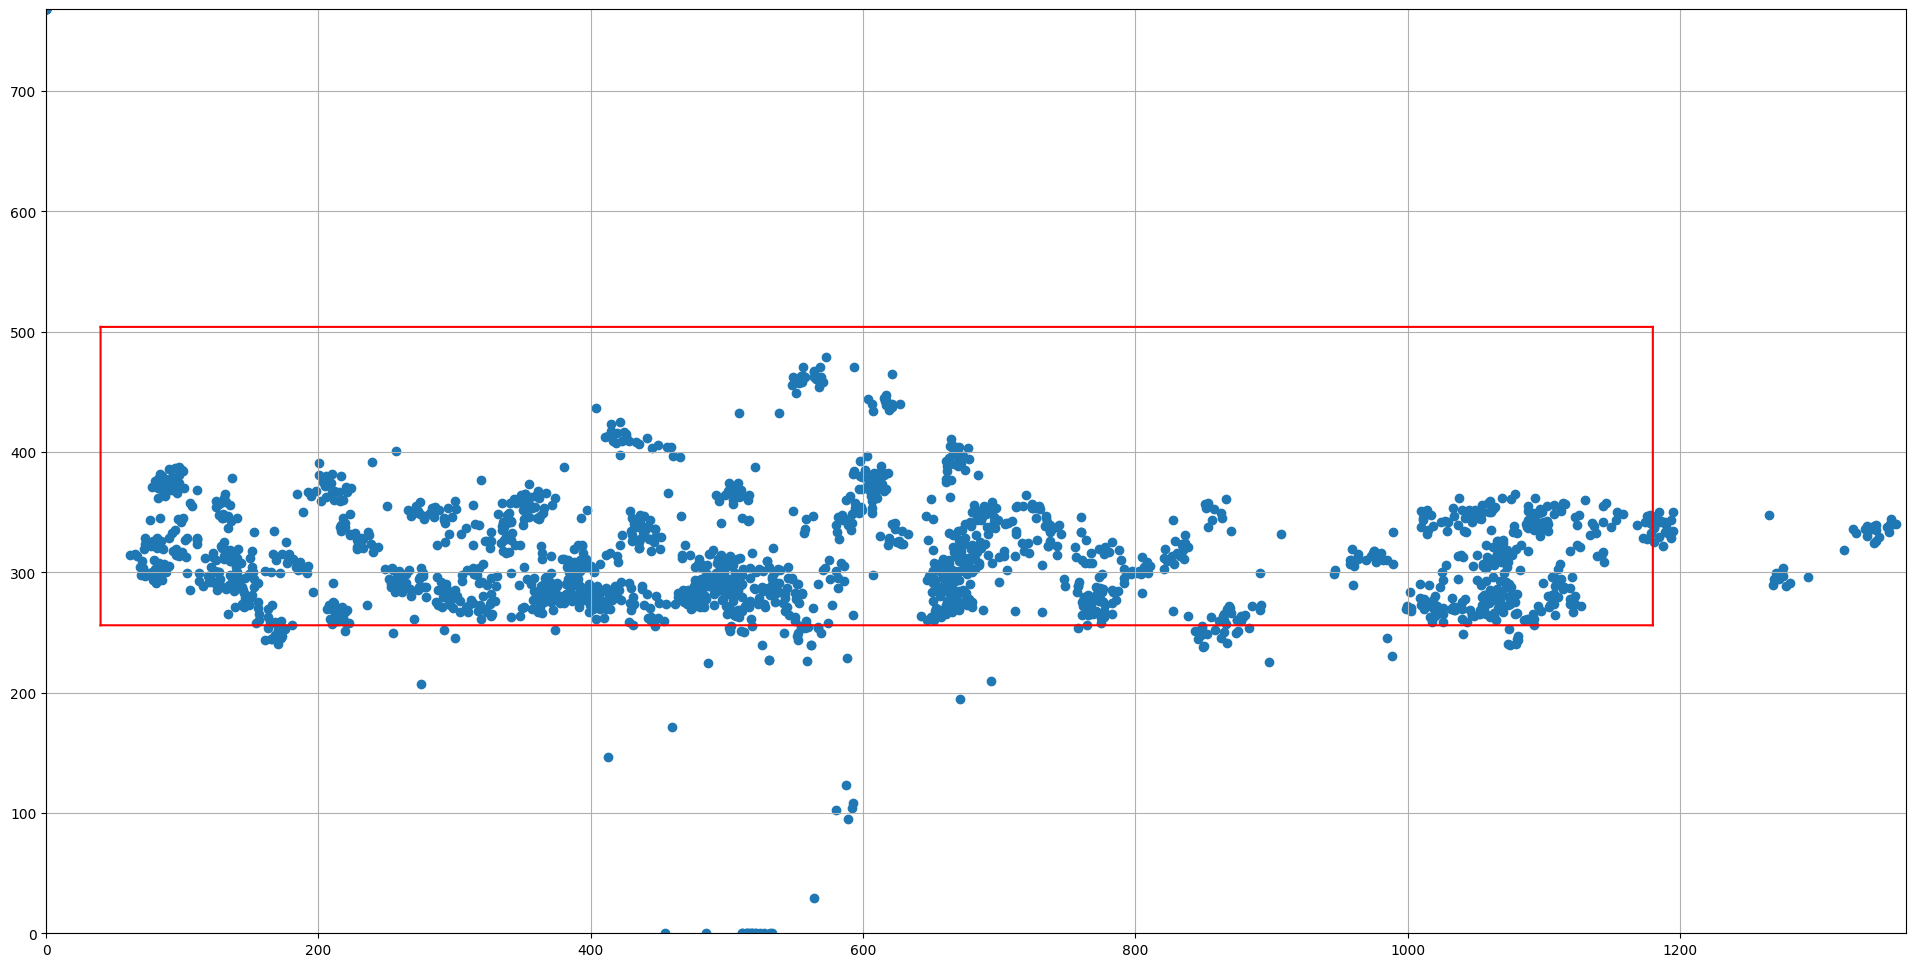

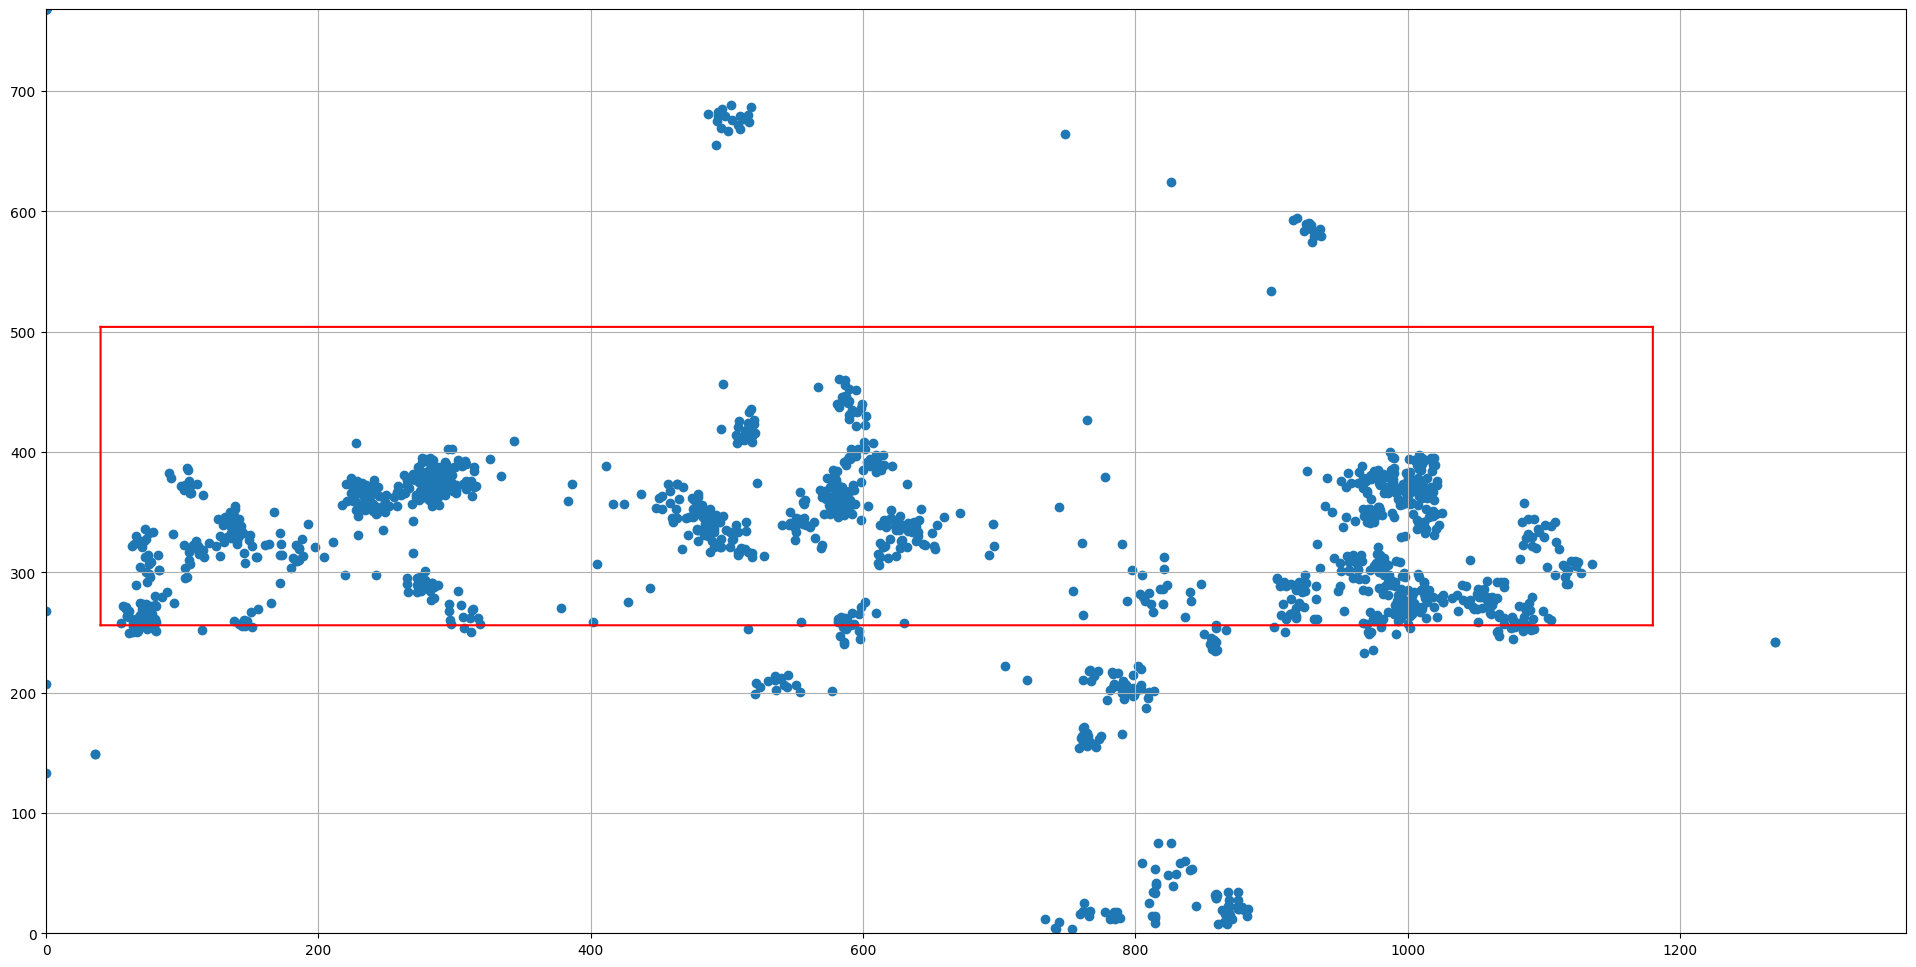

In [16]:
for im_num in range(data_num):
    plt.figure(figsize=(24, 12))
    plt.grid()
    plt.scatter(df_eye_inter[(df_eye_inter["time"]>=start_time[im_num]) & (df_eye_inter["time"]<=end_time[im_num])]["RgazeX"]*x_size,  ((df_eye_inter[(df_eye_inter["time"]>=start_time[im_num]) & (df_eye_inter["time"]<=end_time[im_num])]["RgazeY"])-1)*-y_size)
    plt.plot(screen_x, z_max ,color = "red")
    plt.plot(screen_x, z_min ,color = "red")
    plt.plot(x_max, screen_y ,color = "red")
    plt.plot(x_min, screen_y ,color = "red")
    plt.xlim(0, x_size)
    plt.ylim(0, y_size)
    plt.show()

# 3Dplot個別分析

## 動画4:32秒から録画開始　272秒
## Aさん・21秒後に提示開始、23秒目から説明開始　62秒目まで健常者1の説明
## Aさん・63秒後に提示開始、64秒目から説明開始　92秒目まで健常者2の説明
## Aさん・95秒後に提示開始、97秒目から説明開始　122秒目まで間質性肺炎患者1の説明
## Aさん・123秒後に提示開始、124秒目から説明開始　140秒目まで間質性肺炎患者2の説明

In [32]:
start_time = [21.0,63.0,95.0,123.0]
explain_time = [23.0,64.0,97.0,124.0]
end_time = [62.0,92.0,122.0,140.0]

In [33]:
x_size = 1366
y_size = 768
screen_x = np.linspace(340.0, 930.0, 10000)
z_max = np.linspace(y_size-665, y_size-665, 10000)
z_min = np.linspace(y_size-130, y_size-130, 10000)

screen_y = np.linspace(y_size-665, y_size-130, 10000)
x_max = np.linspace(930, 930, 10000)
x_min = np.linspace(340, 340, 10000)

high_freq = np.linspace(y_size-360, y_size-360, 10000)

# Lgaze

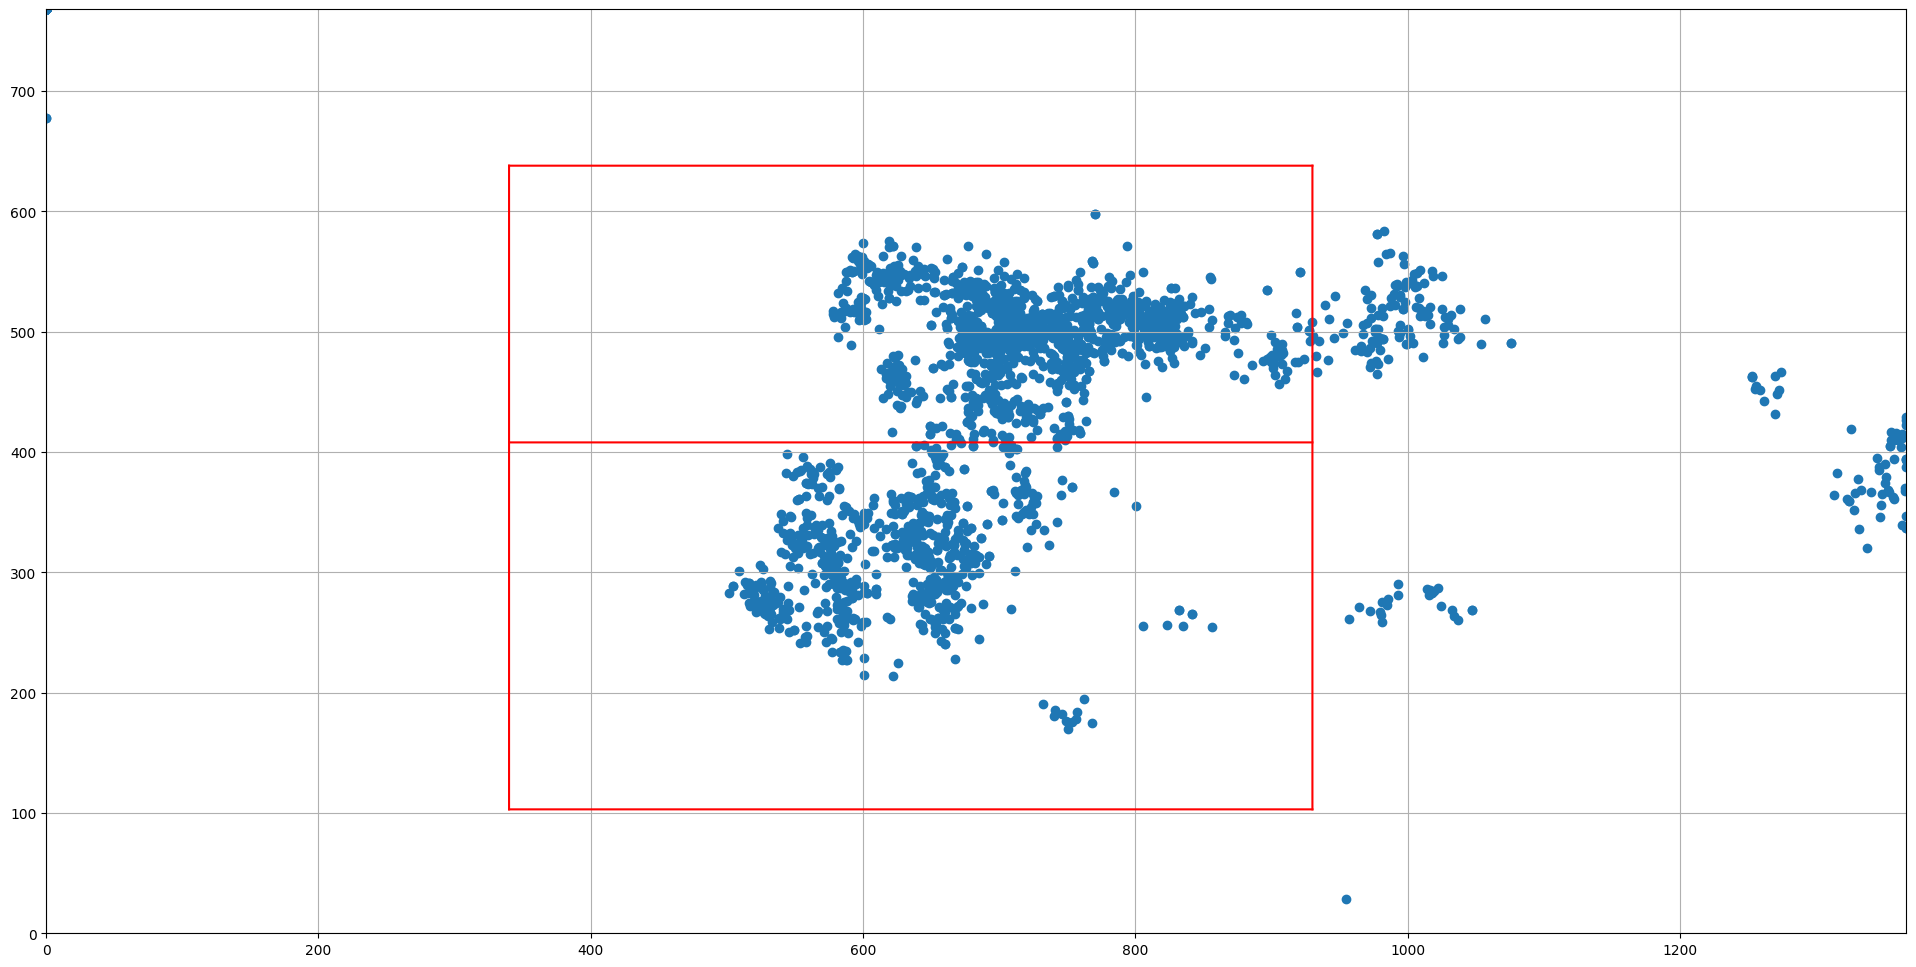

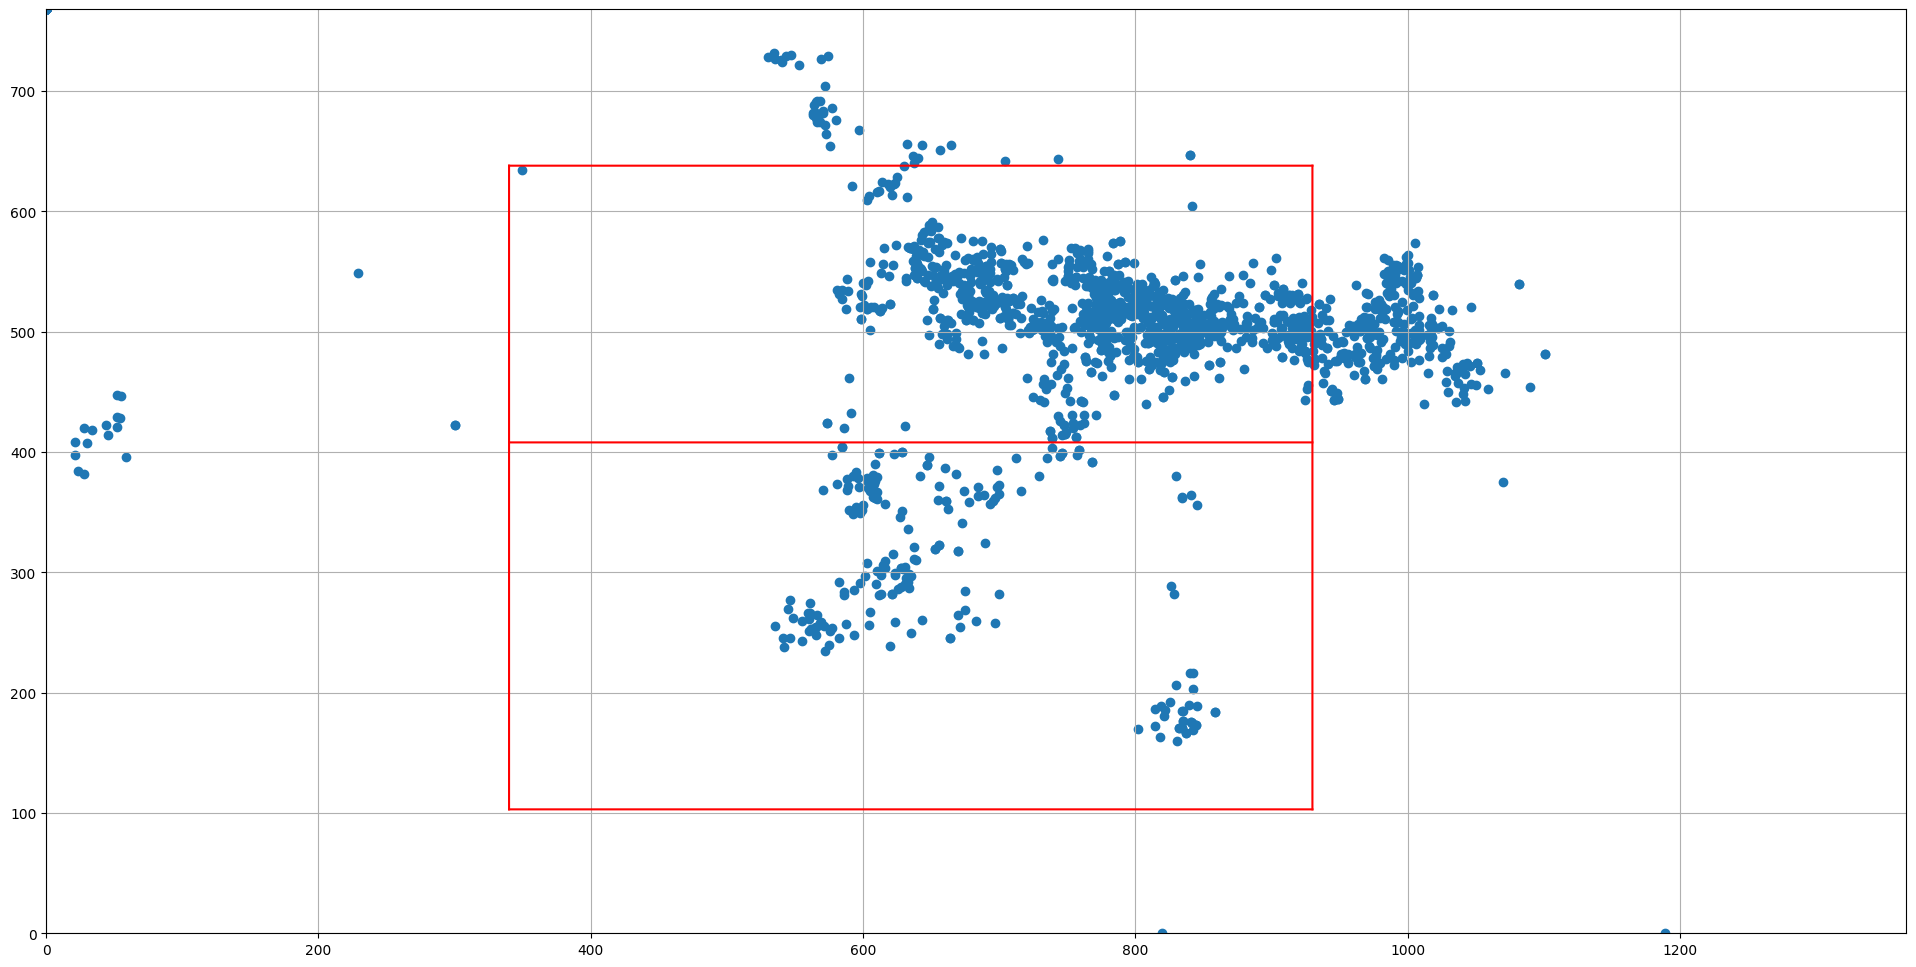

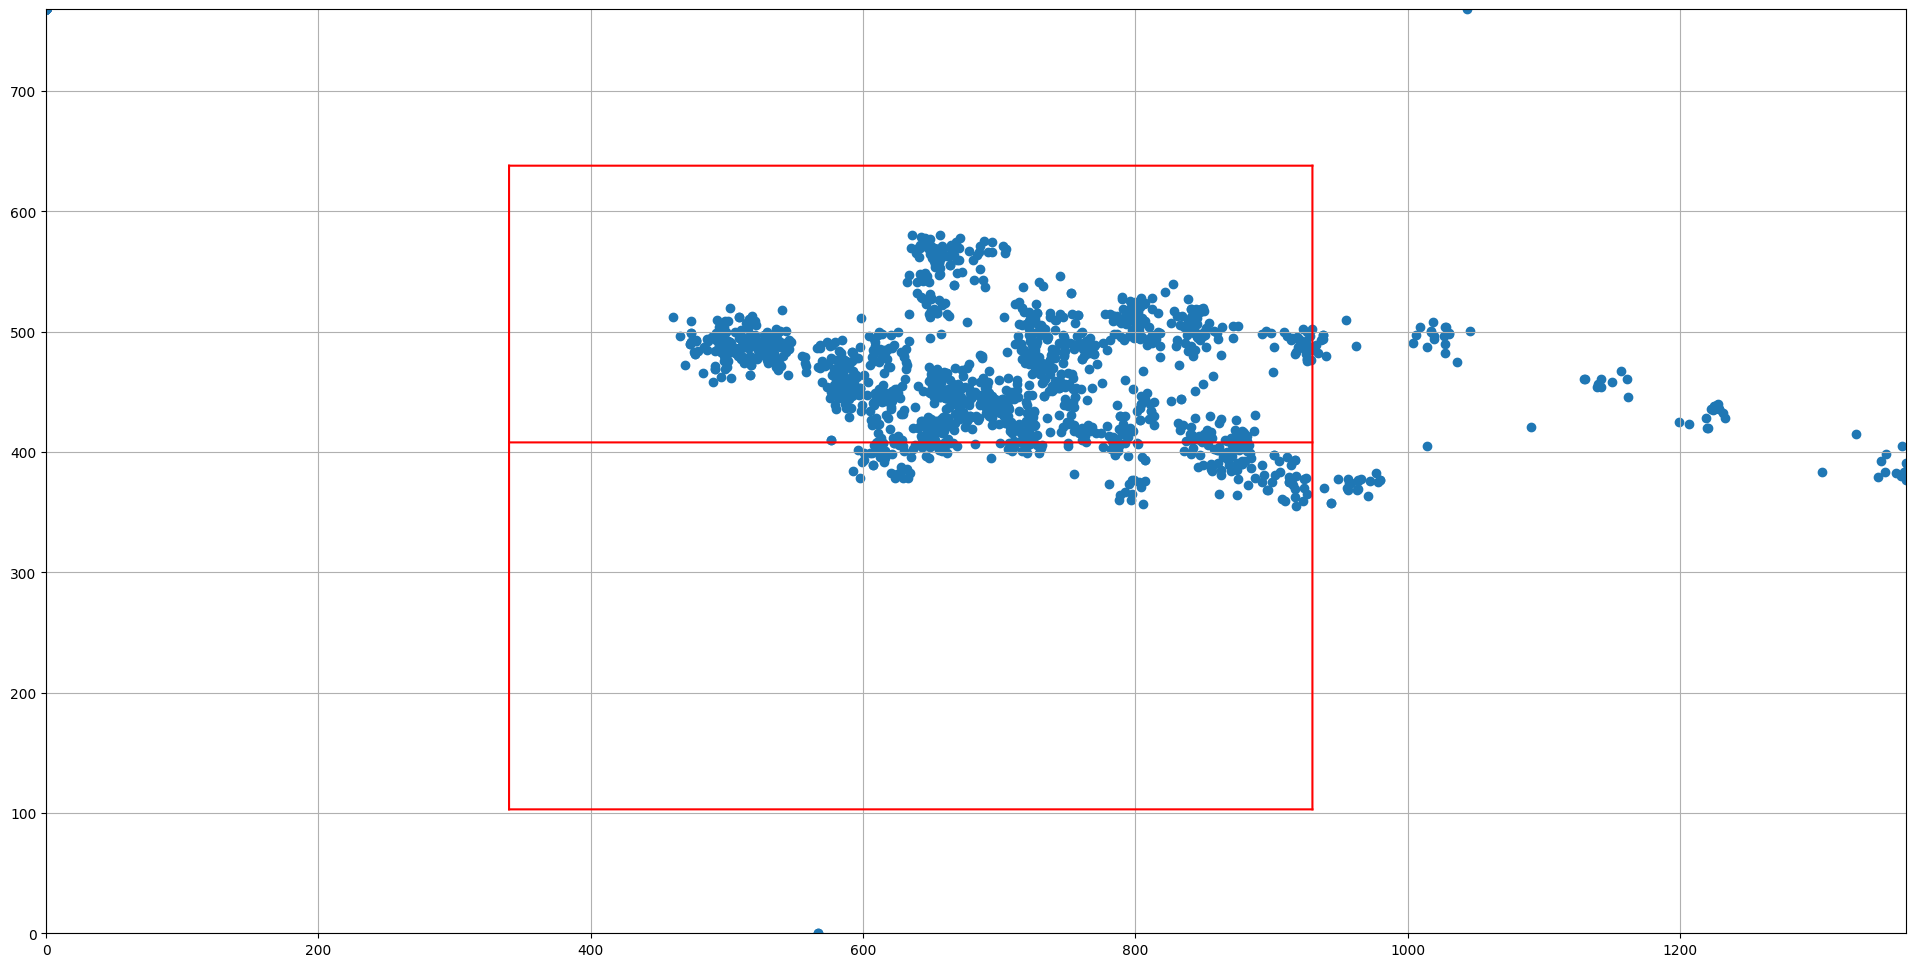

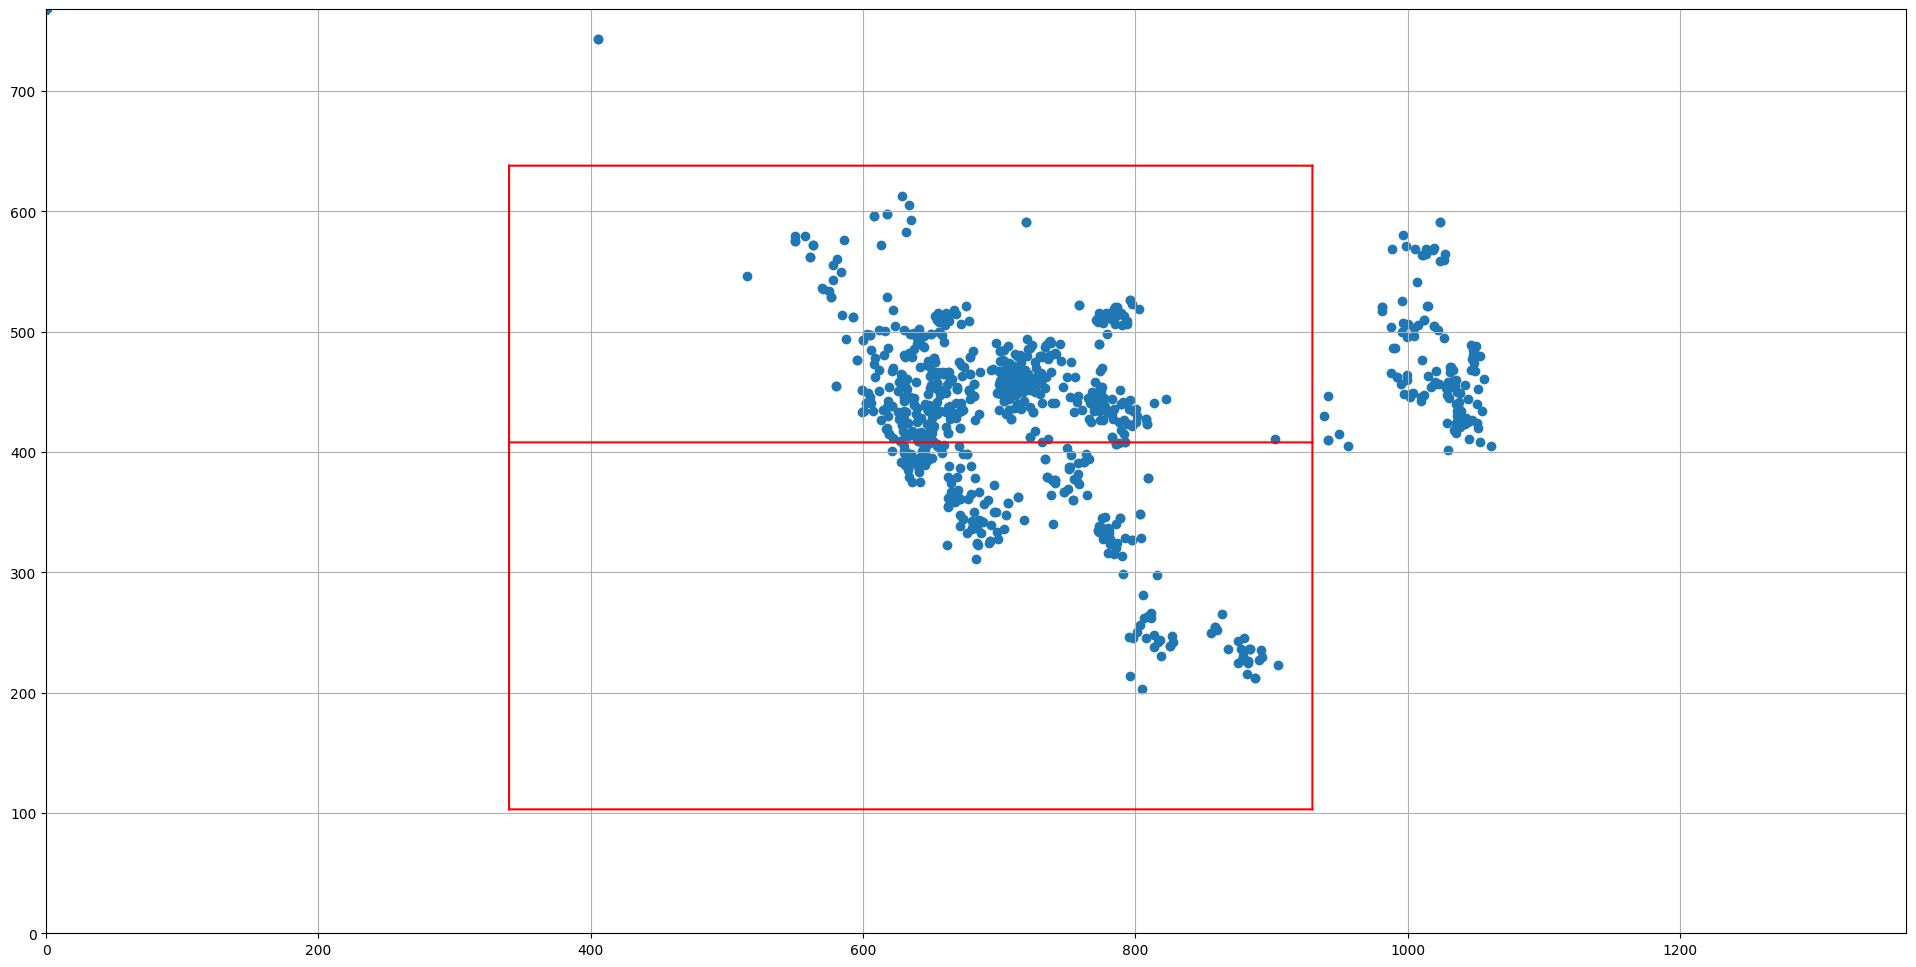

In [34]:
for im_num in range(data_num):
    plt.figure(figsize=(24, 12))
    plt.grid()
    plt.scatter(df_eye_inter_plot[(df_eye_inter_plot["time"]>=start_time[im_num]) & (df_eye_inter_plot["time"]<=end_time[im_num])]["LgazeX"]*x_size,  ((df_eye_inter_plot[(df_eye_inter["time"]>=start_time[im_num]) & (df_eye_inter_plot["time"]<=end_time[im_num])]["LgazeY"])-1)*-y_size)
    plt.plot(screen_x, z_max ,color = "red")
    plt.plot(screen_x, z_min ,color = "red")
    
    plt.plot(screen_x, high_freq ,color = "red")
    
    plt.plot(x_max, screen_y ,color = "red")
    plt.plot(x_min, screen_y ,color = "red")
    
    plt.xlim(0, x_size)
    plt.ylim(0, y_size)
    
    plt.show()

# Rgaze

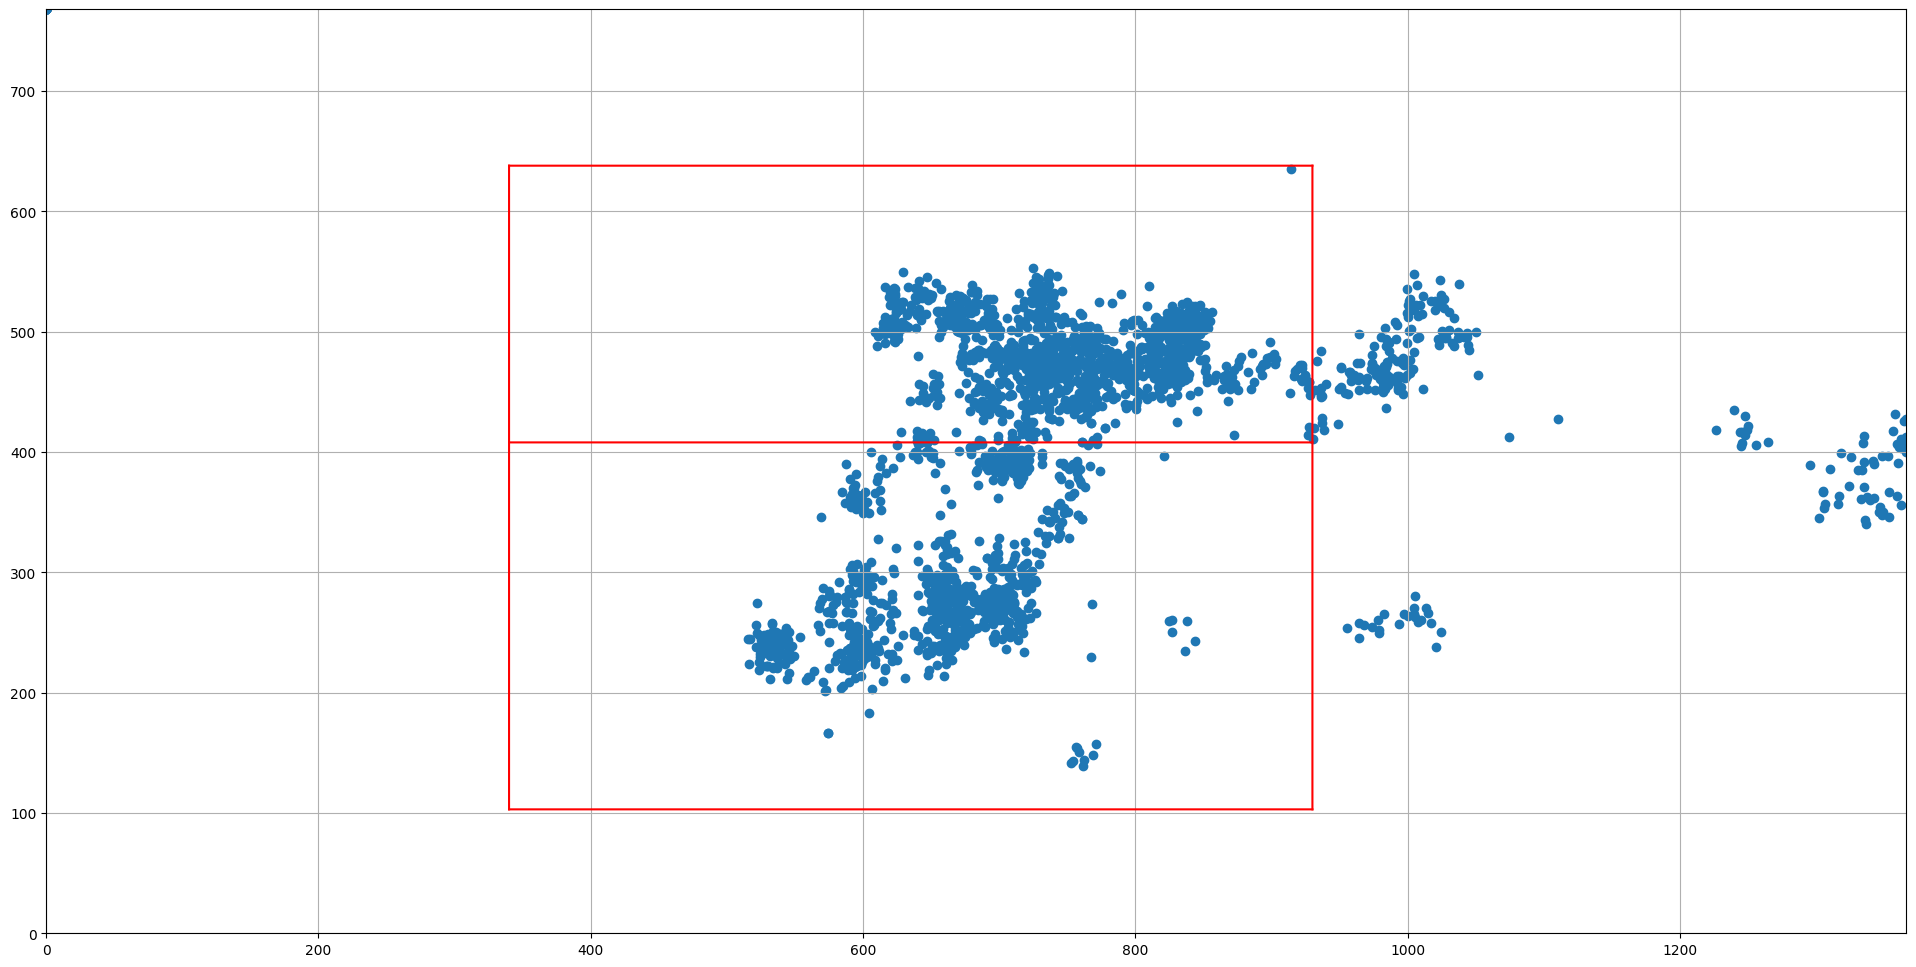

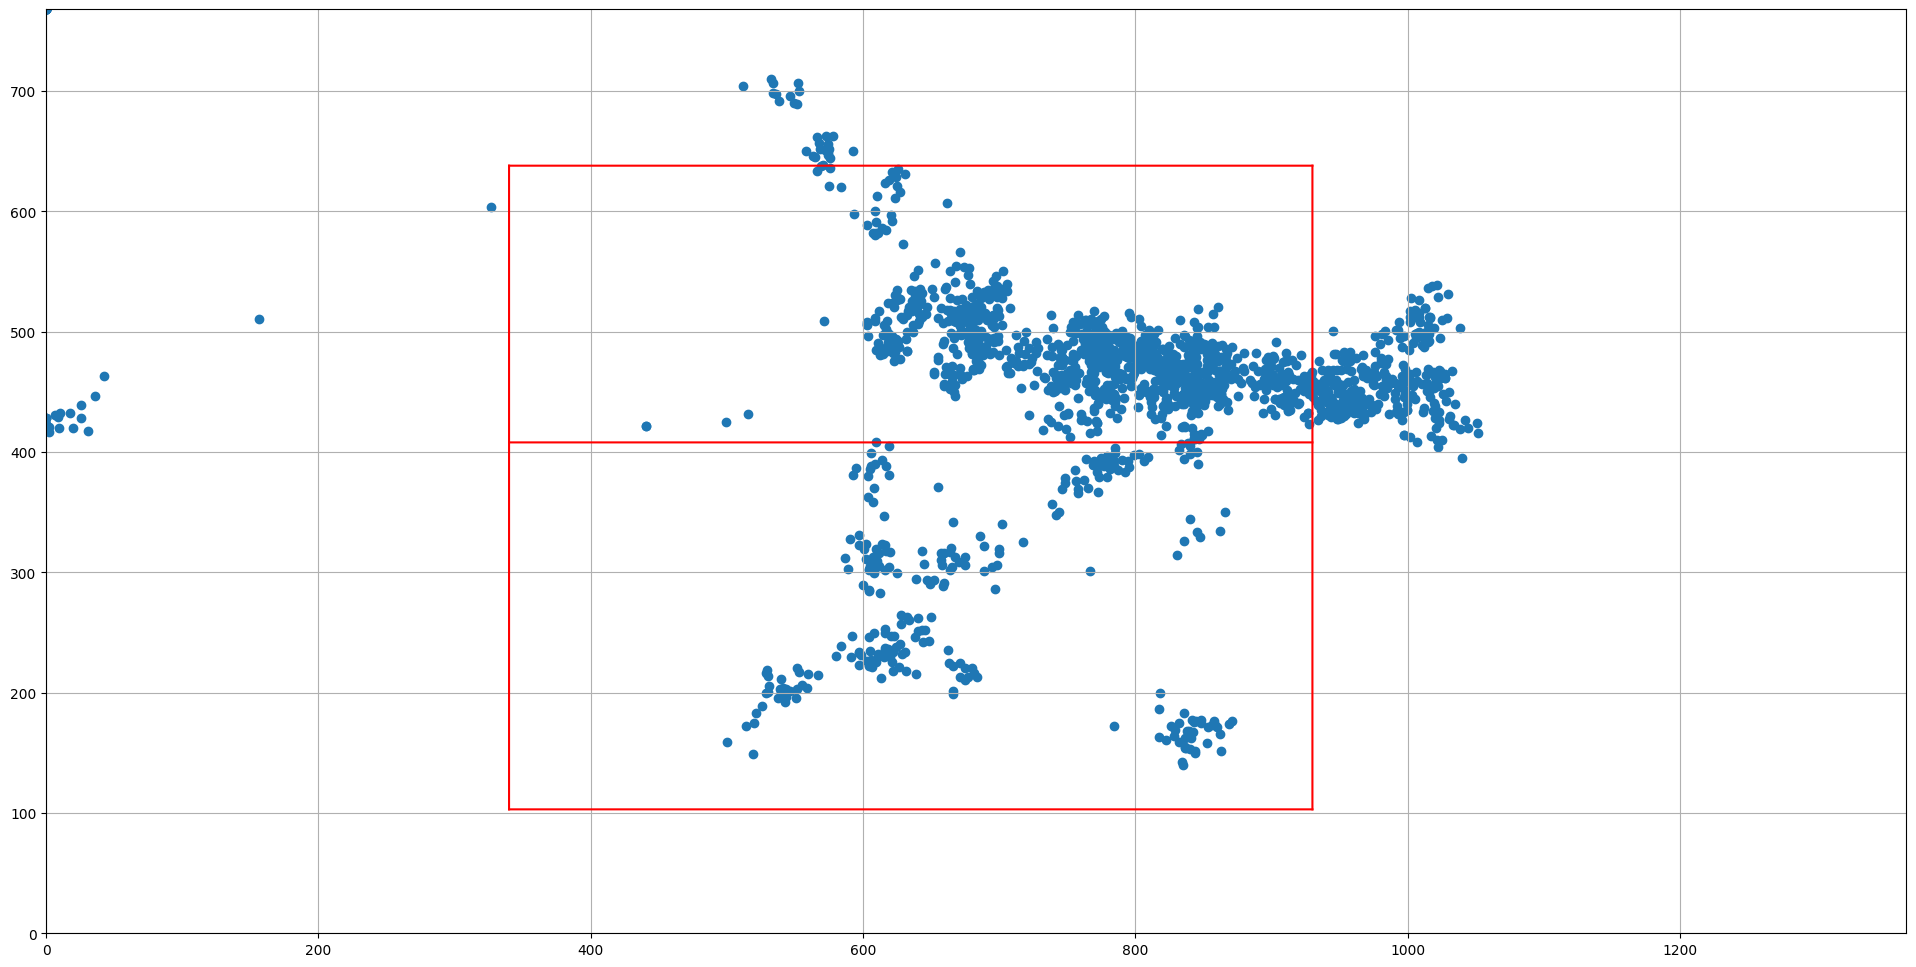

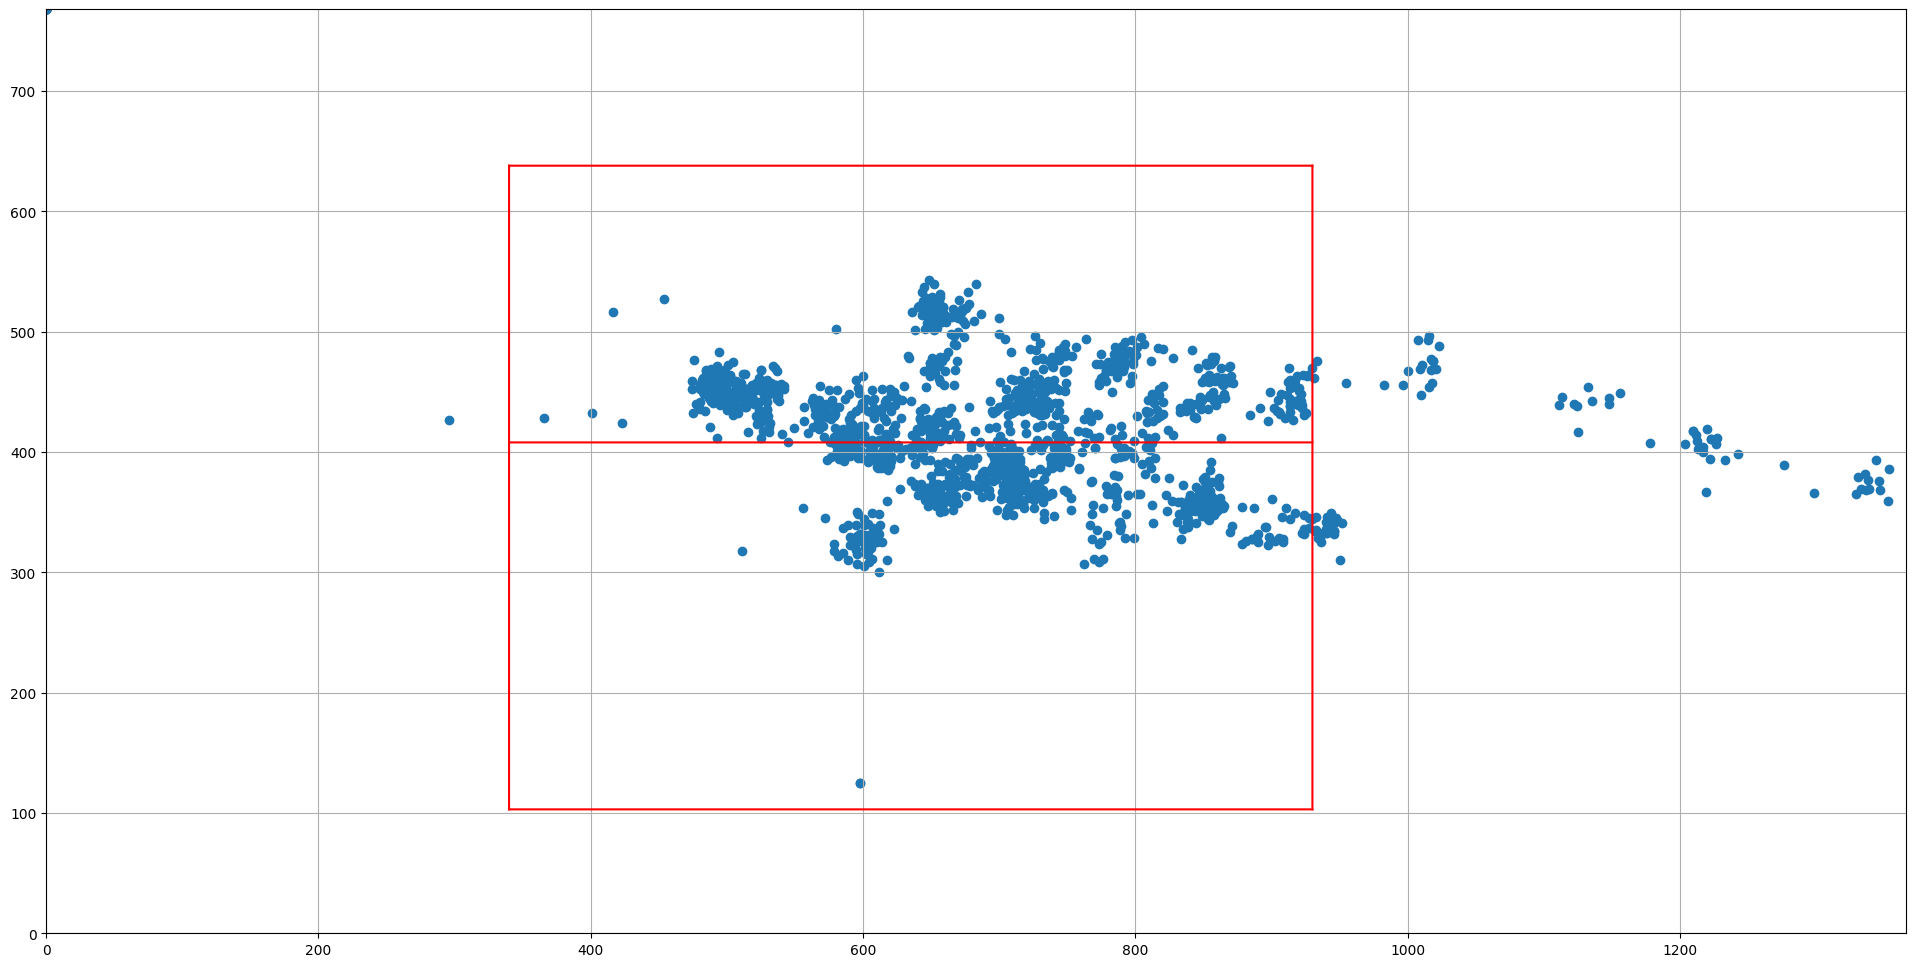

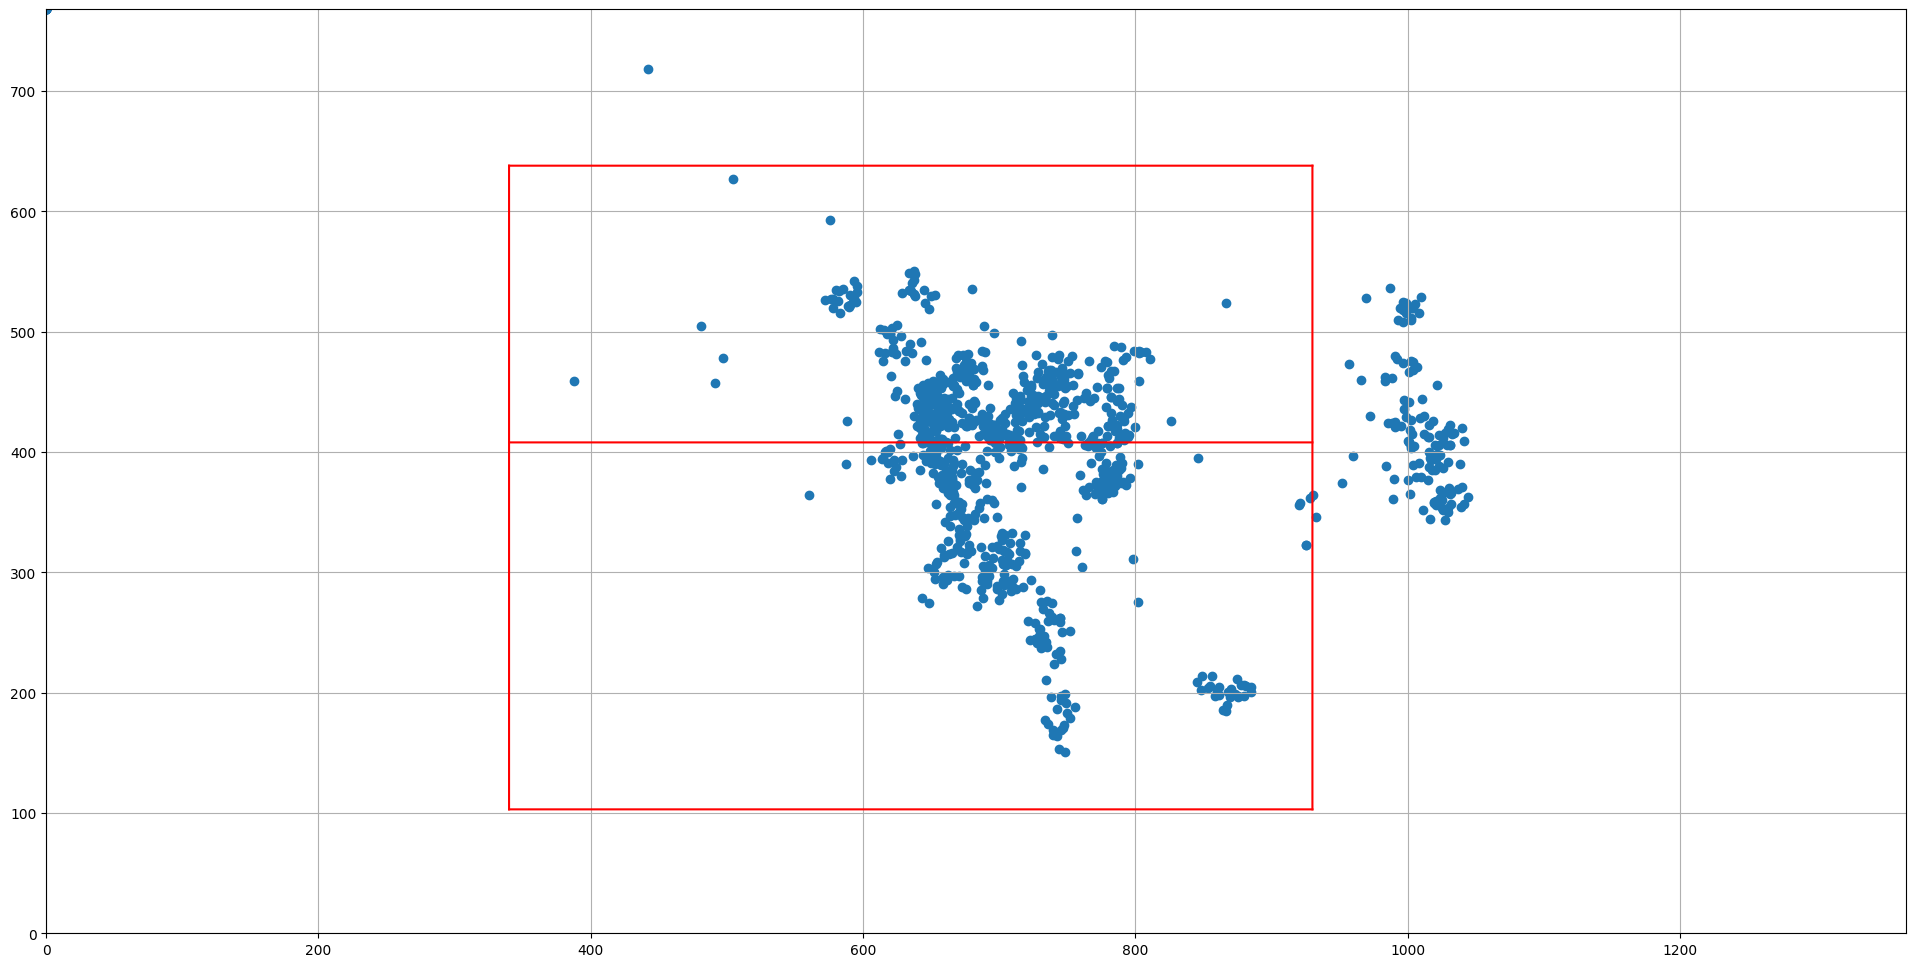

In [35]:
for im_num in range(data_num):
    plt.figure(figsize=(24, 12))
    plt.grid()
    plt.scatter(df_eye_inter_plot[(df_eye_inter_plot["time"]>=start_time[im_num]) & (df_eye_inter_plot["time"]<=end_time[im_num])]["RgazeX"]*x_size,  ((df_eye_inter_plot[(df_eye_inter["time"]>=start_time[im_num]) & (df_eye_inter_plot["time"]<=end_time[im_num])]["RgazeY"])-1)*-y_size)
    plt.plot(screen_x, z_max ,color = "red")
    plt.plot(screen_x, z_min ,color = "red")
    
    plt.plot(screen_x, high_freq ,color = "red")
    
    plt.plot(x_max, screen_y ,color = "red")
    plt.plot(x_min, screen_y ,color = "red")
    
    plt.xlim(0, x_size)
    plt.ylim(0, y_size)
    plt.show()

# 3D Animation個別分析

## 7分26秒から録画開始　446秒
## Aさん・15秒後に提示開始、15秒目から説明開始　42秒目まで健常者1の説明
## Aさん・51秒後に提示開始、51秒目から説明開始　82秒目まで健常者2の説明
## Aさん・92秒後に提示開始、92秒目から説明開始　121秒目まで間質性肺炎患者1の説明
## Aさん・129秒後に提示開始、129秒目から説明開始　157秒目まで間質性肺炎患者2の説明

In [24]:
start_time = [15.0,51.0,92.0,129.0]
explain_time = [15.0,51.0,92.0,129.0]
end_time = [42.0,82.0,121.0,157.0]

In [36]:
x_size = 1366
y_size = 768
screen_x = np.linspace(220.0, 870.0, 10000)
z_max = np.linspace(y_size-700, y_size-700, 10000)
z_min = np.linspace(y_size-100, y_size-100, 10000)

screen_y = np.linspace(y_size-700, y_size-100, 10000)
x_max = np.linspace(870, 870, 10000)
x_min = np.linspace(220, 220, 10000)

high_freq = np.linspace(y_size-300, y_size-300, 10000)

# Lgaze

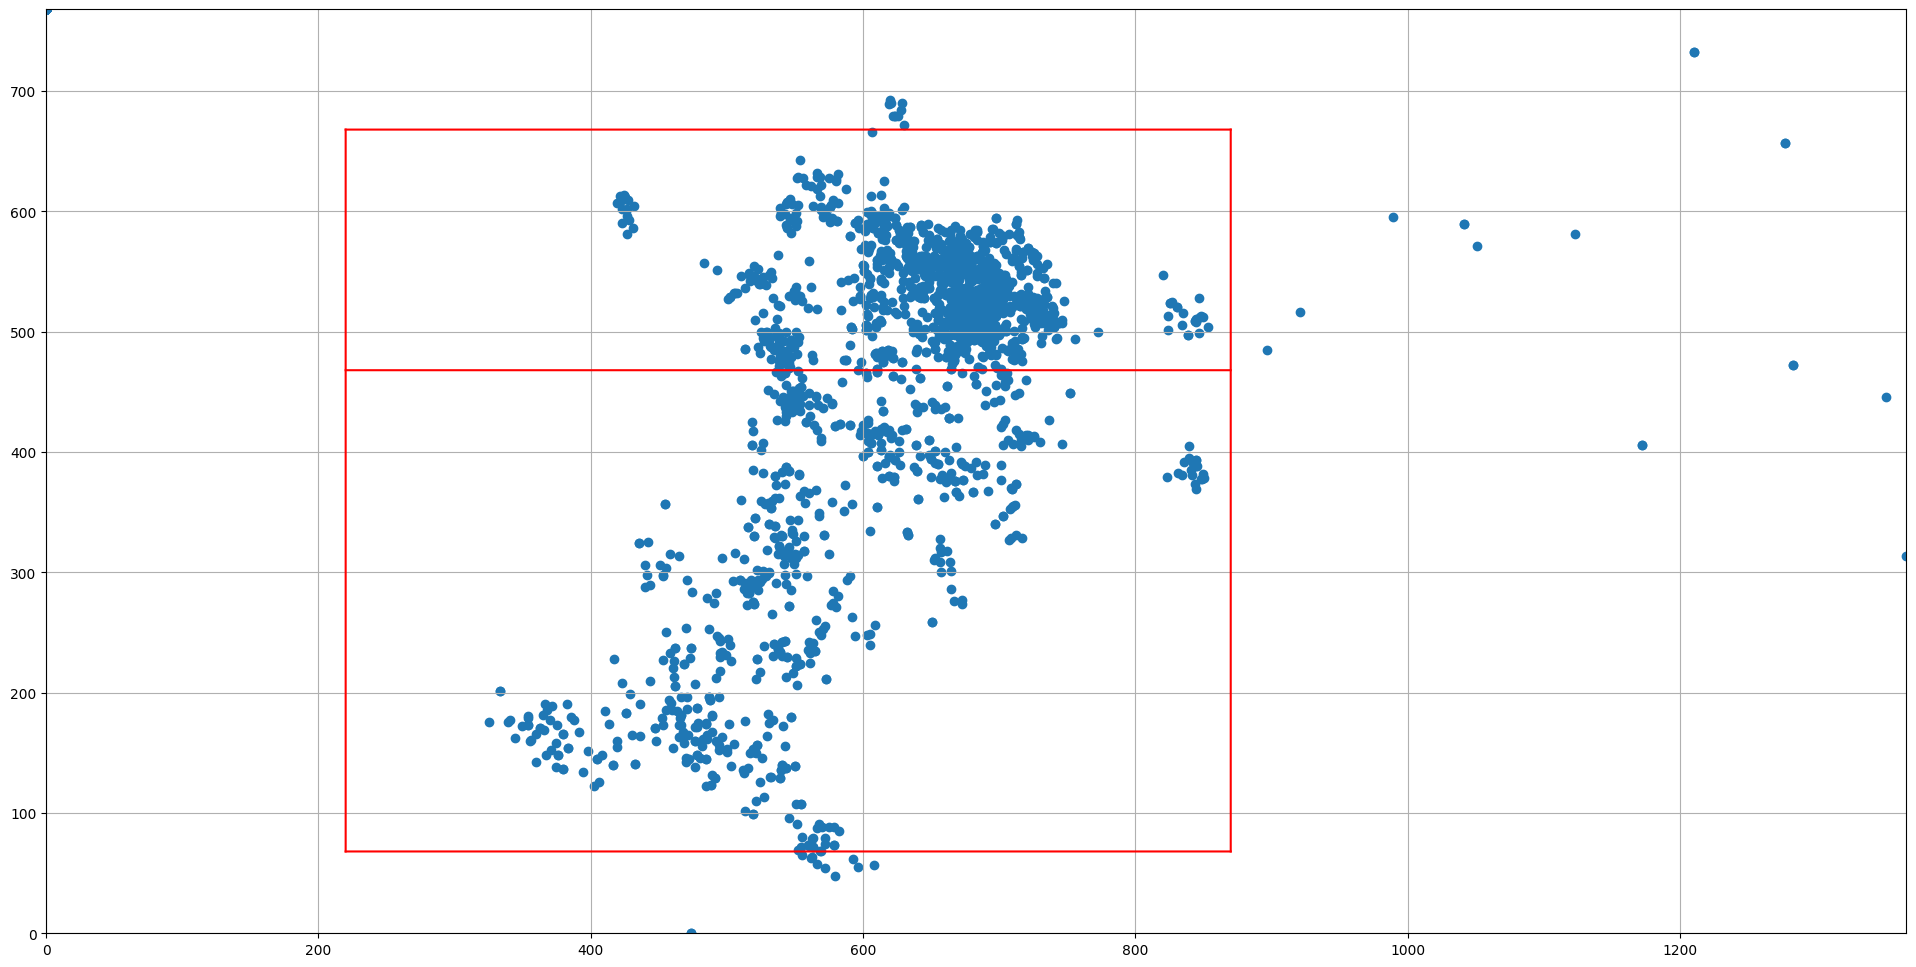

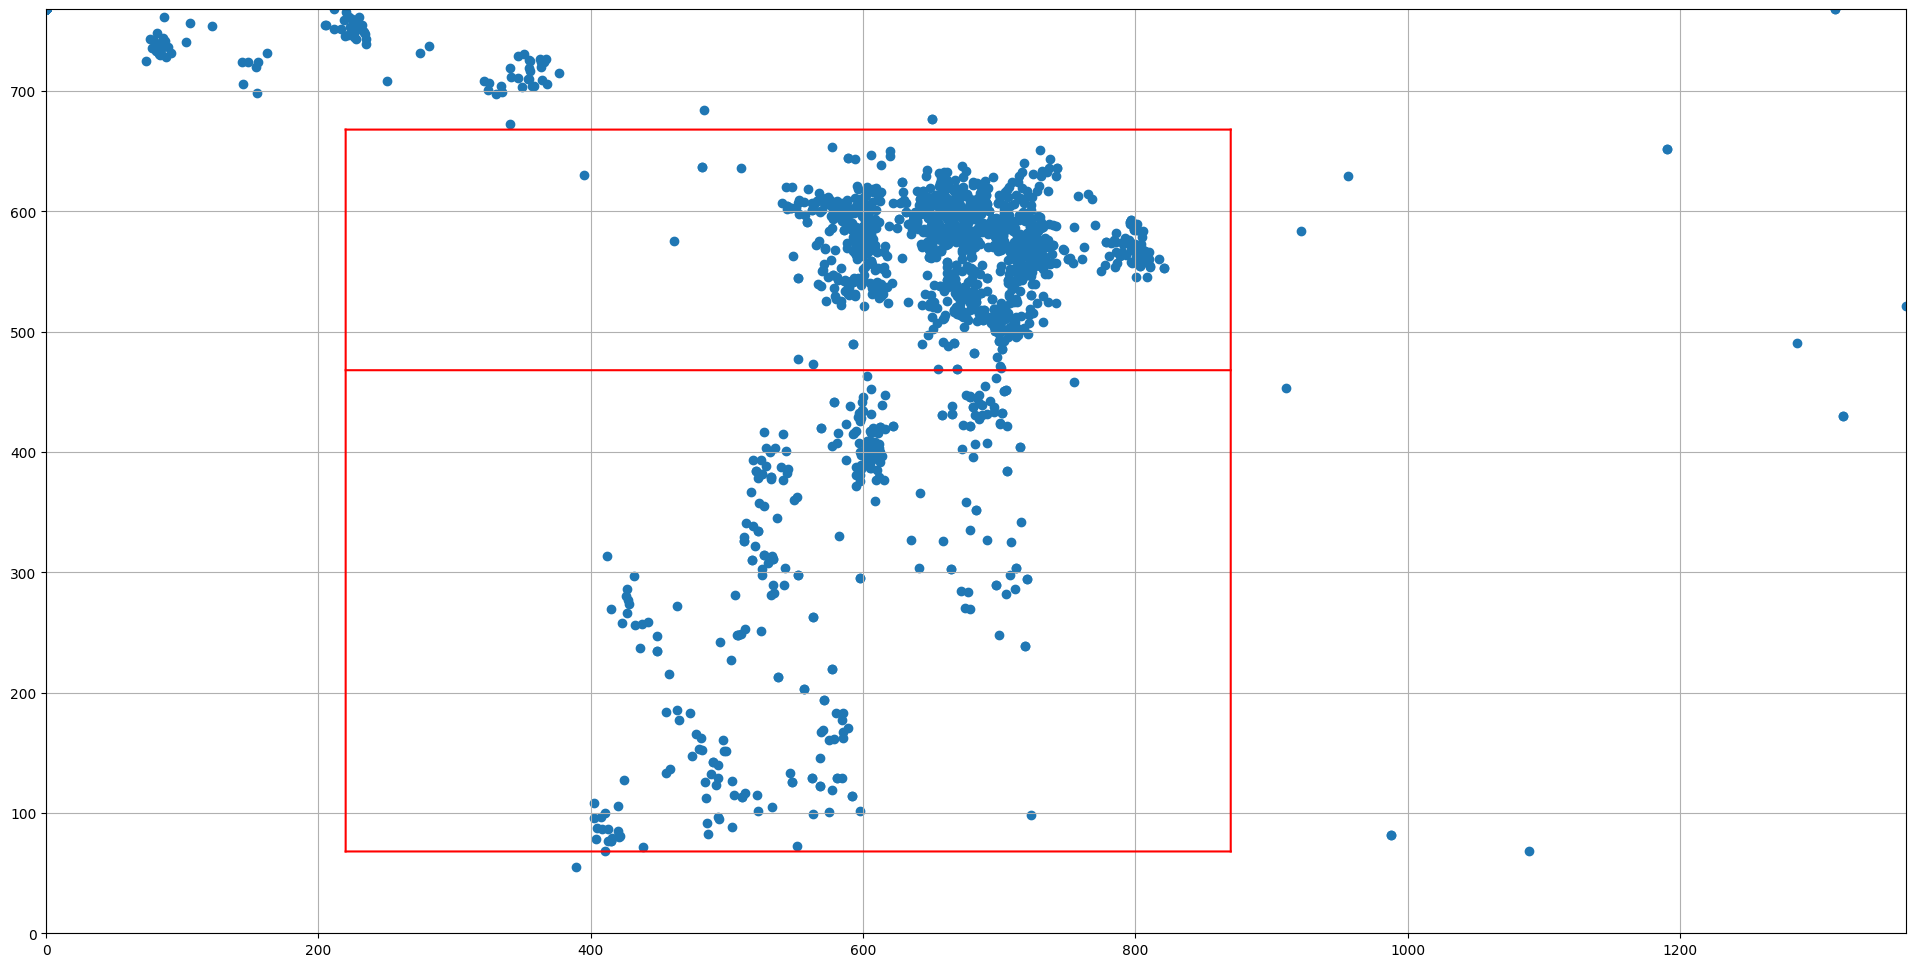

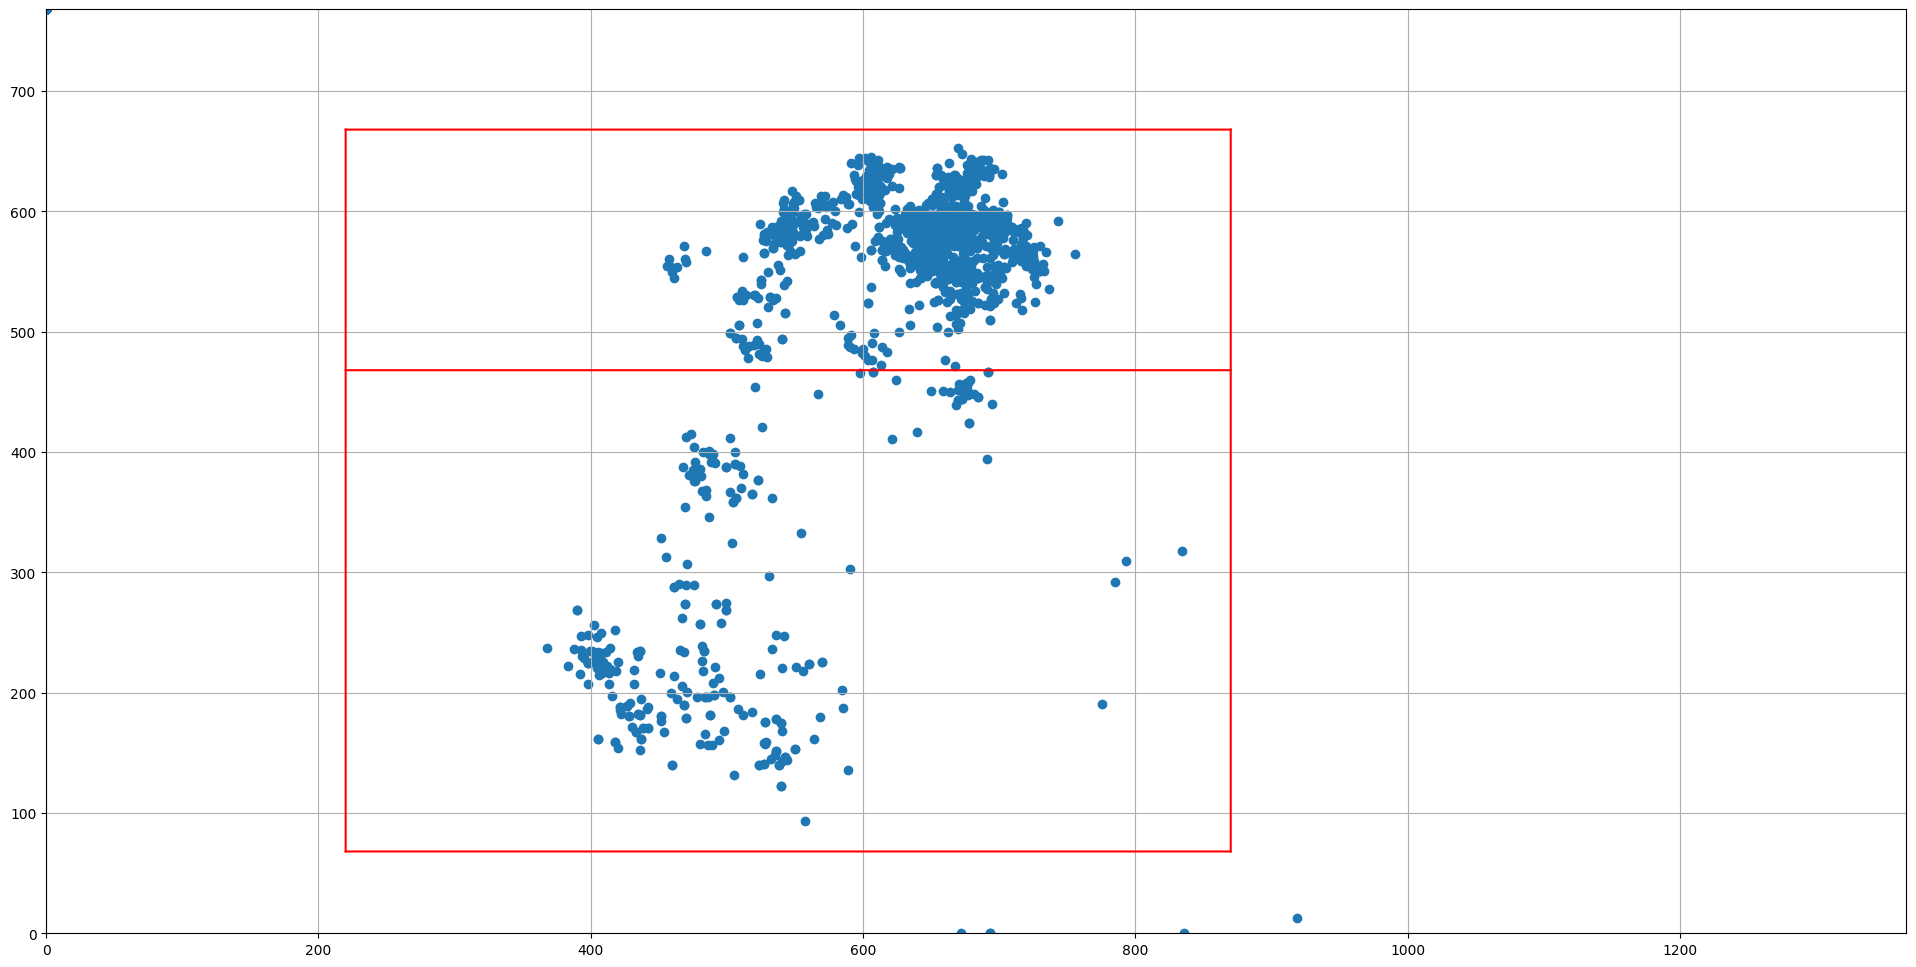

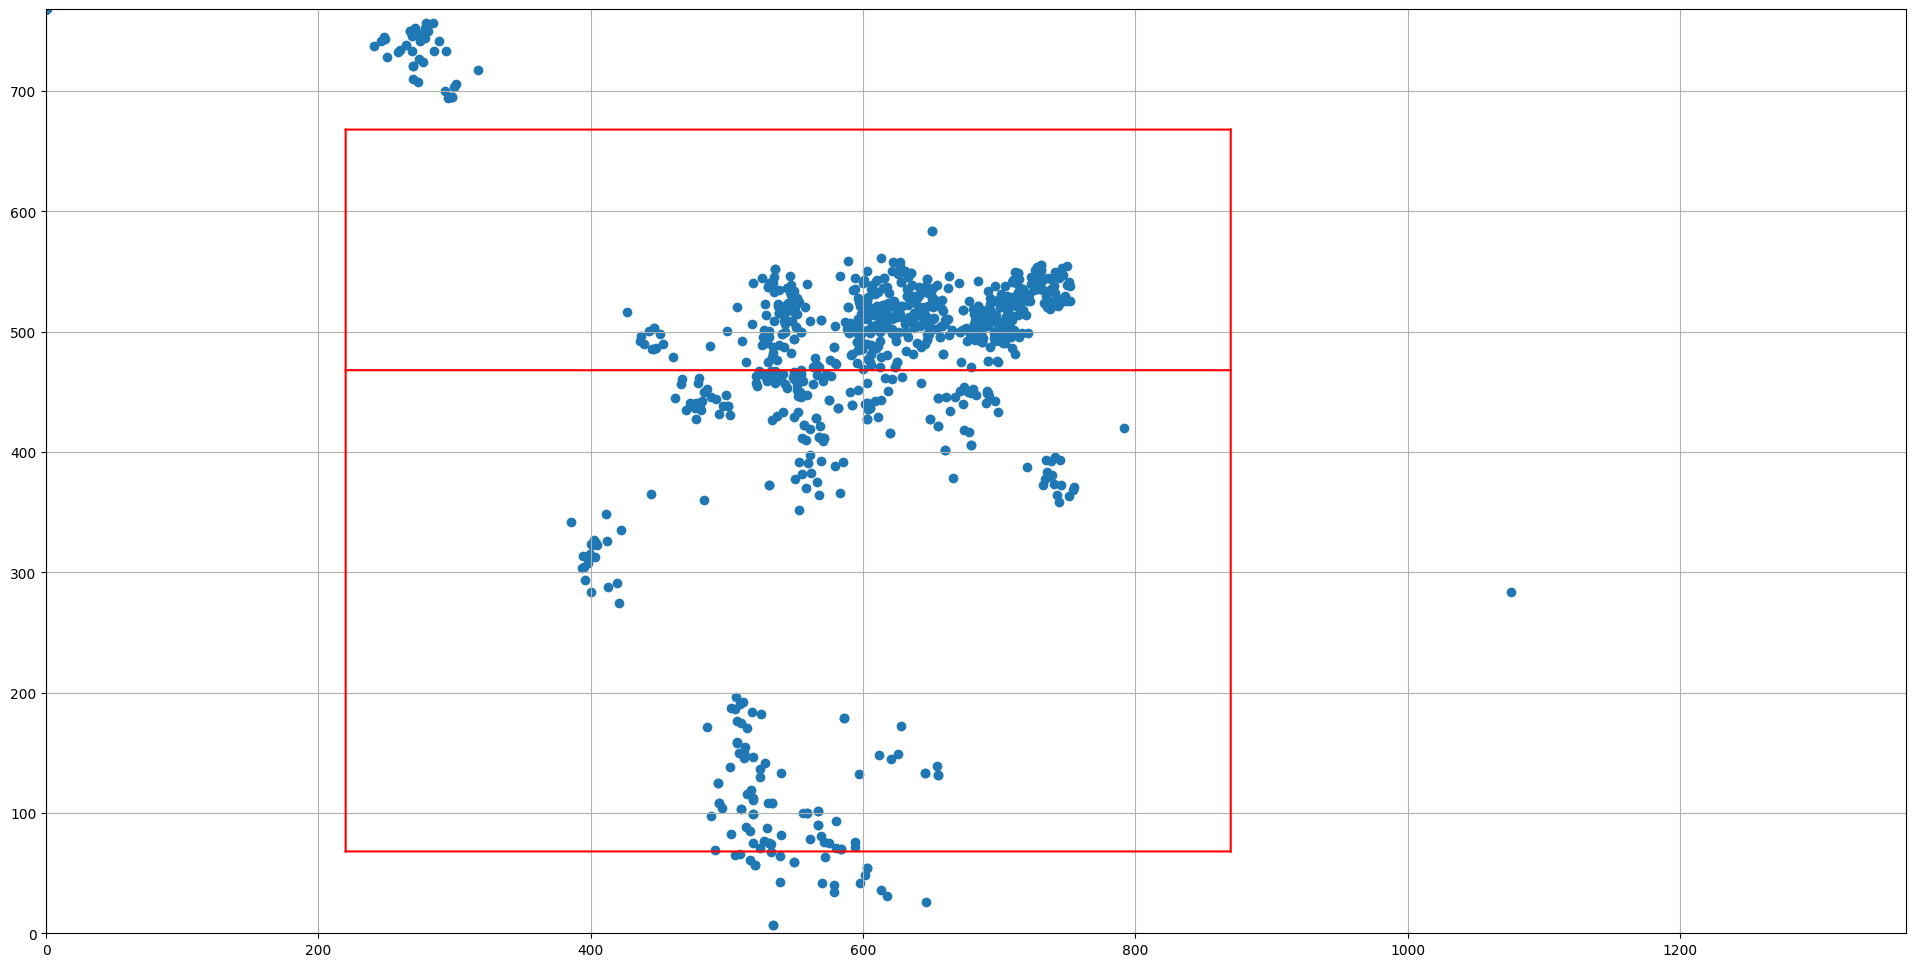

In [37]:
for im_num in range(data_num):
    plt.figure(figsize=(24, 12))
    plt.grid()
    plt.scatter(df_eye_inter_anime[(df_eye_inter_anime["time"]>=start_time[im_num]) & (df_eye_inter_anime["time"]<=end_time[im_num])]["LgazeX"]*x_size,  ((df_eye_inter_anime[(df_eye_inter["time"]>=start_time[im_num]) & (df_eye_inter_anime["time"]<=end_time[im_num])]["LgazeY"])-1)*-y_size)
    plt.plot(screen_x, z_max ,color = "red")
    plt.plot(screen_x, z_min ,color = "red")
    plt.plot(screen_x, high_freq ,color = "red")
    plt.plot(x_max, screen_y ,color = "red")
    plt.plot(x_min, screen_y ,color = "red")
    
    plt.xlim(0, x_size)
    plt.ylim(0, y_size)
    plt.show()

# Rgaze

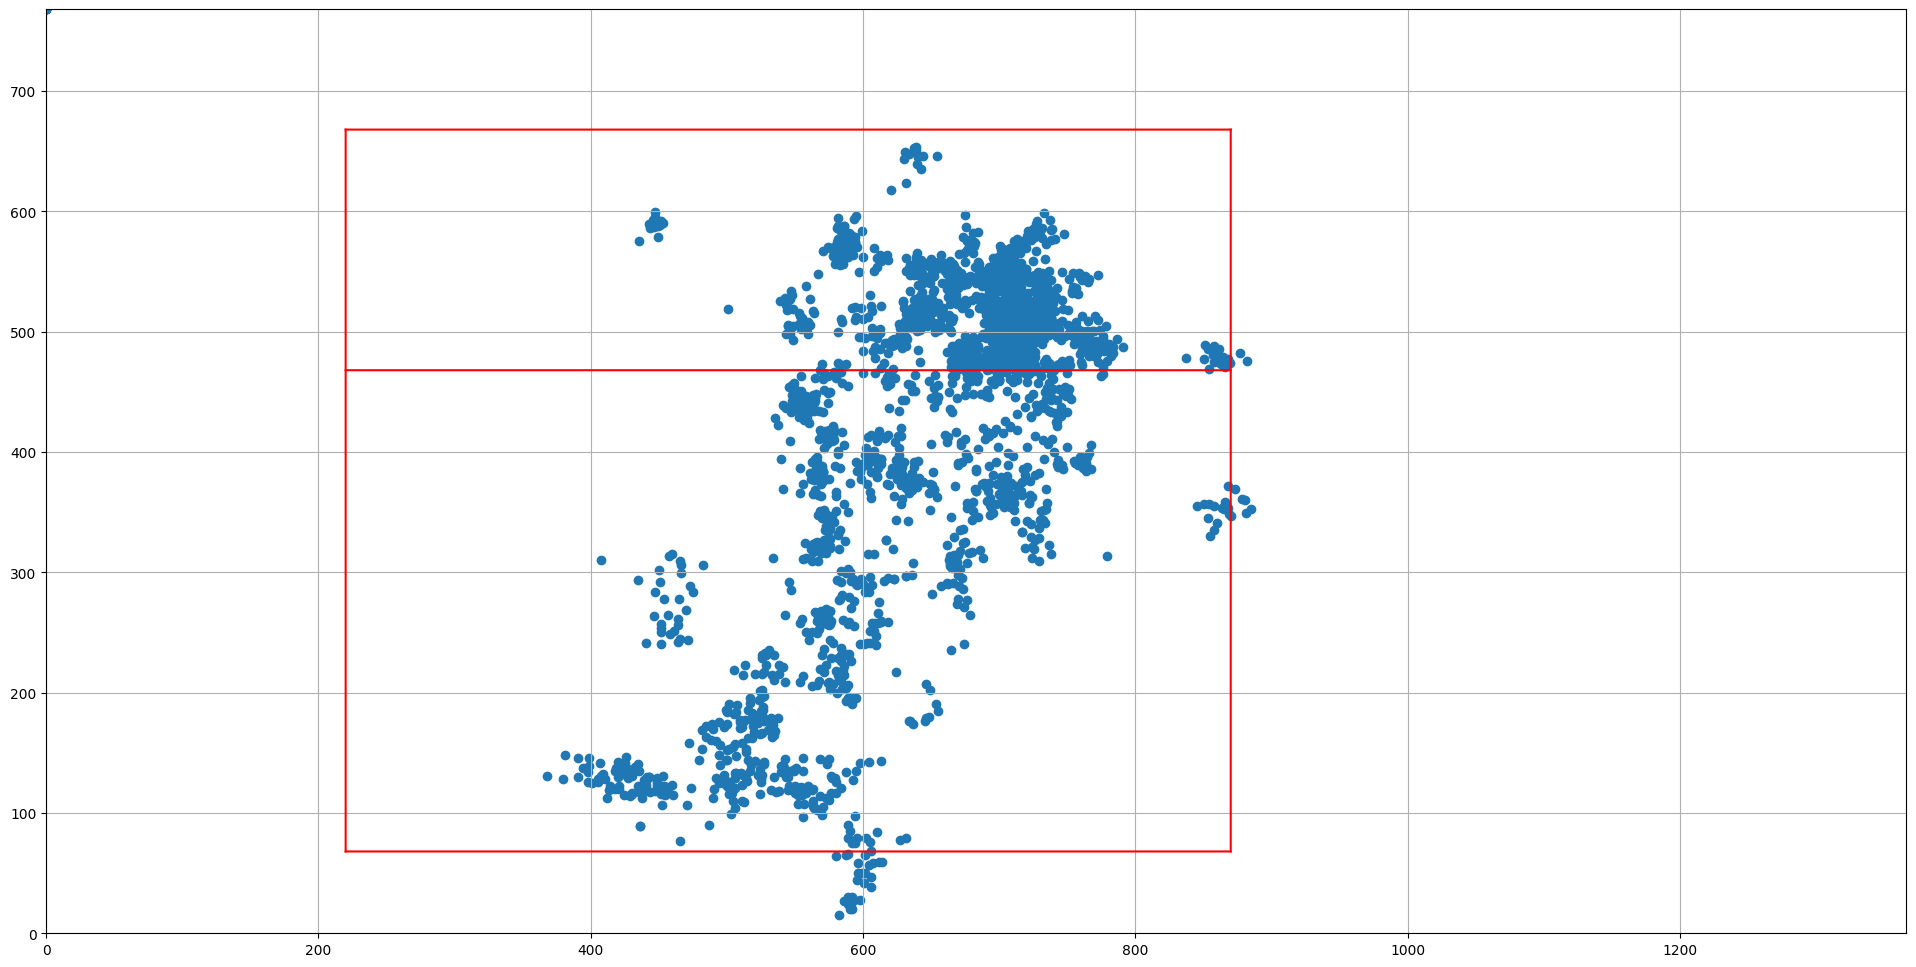

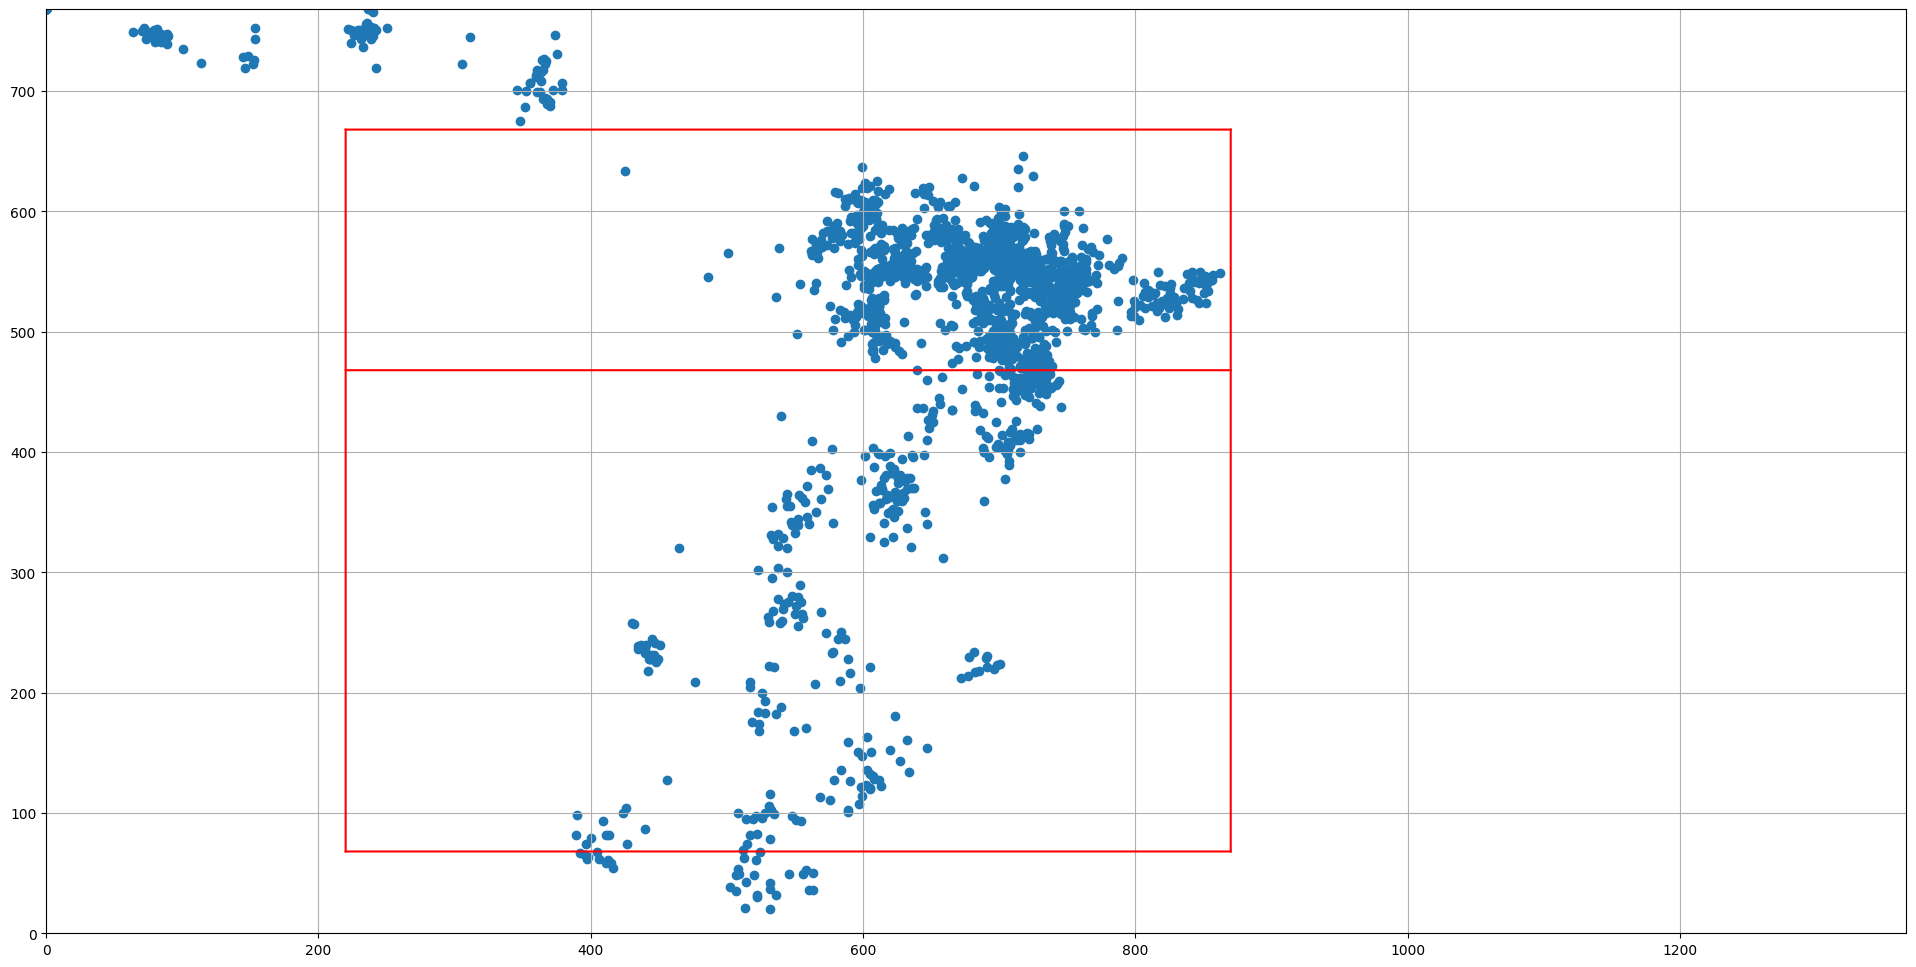

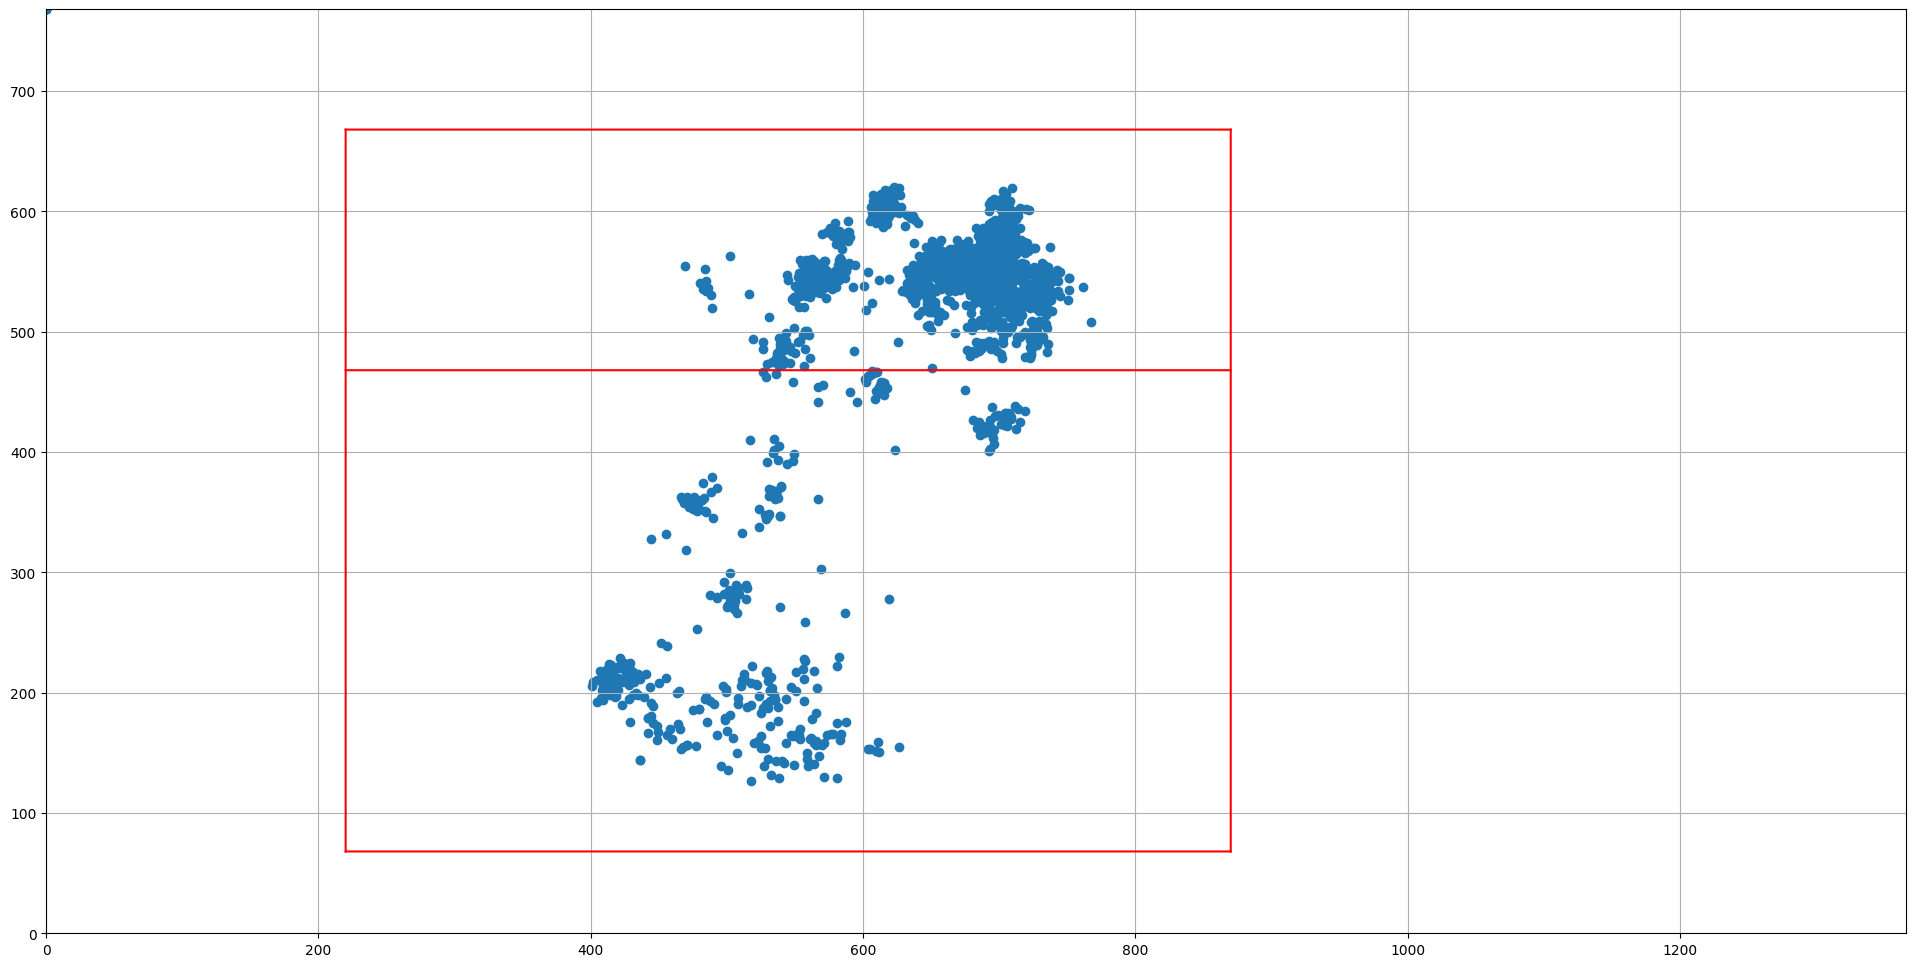

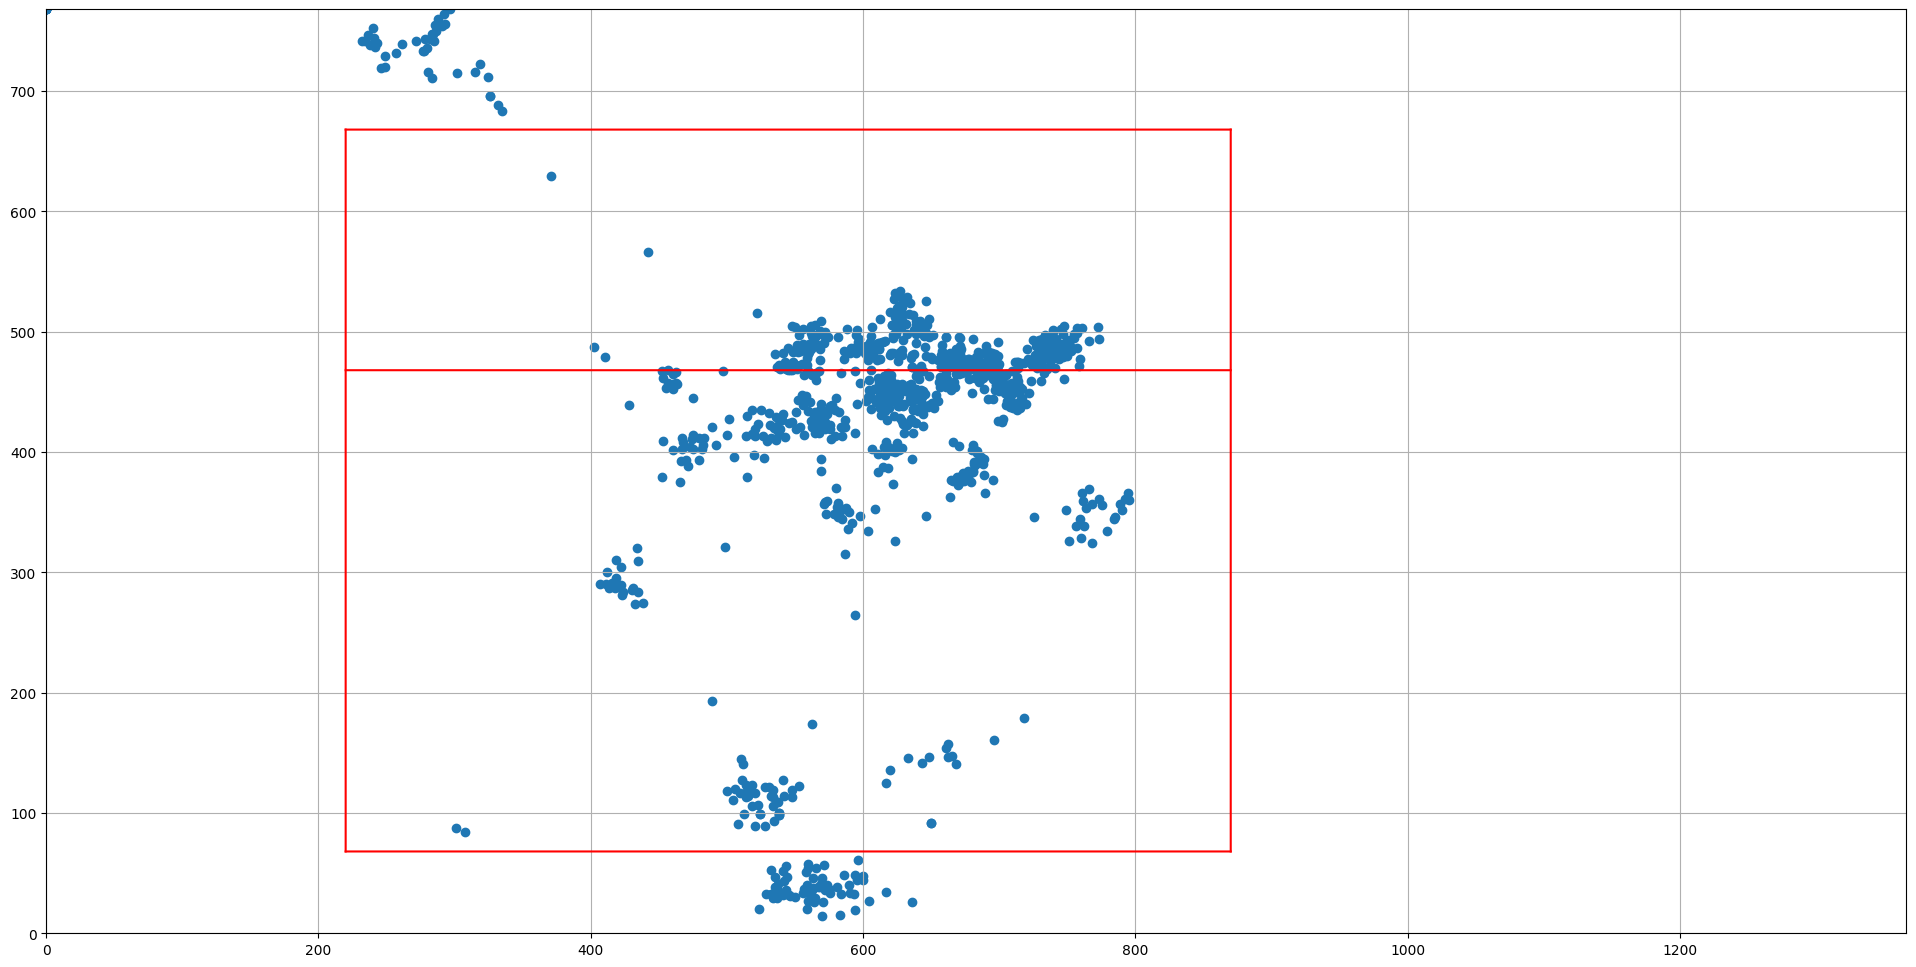

In [38]:
for im_num in range(data_num):
    plt.figure(figsize=(24, 12))
    plt.grid()
    plt.scatter(df_eye_inter_anime[(df_eye_inter_anime["time"]>=start_time[im_num]) & (df_eye_inter_anime["time"]<=end_time[im_num])]["RgazeX"]*x_size,  ((df_eye_inter_anime[(df_eye_inter["time"]>=start_time[im_num]) & (df_eye_inter_anime["time"]<=end_time[im_num])]["RgazeY"])-1)*-y_size)
    plt.plot(screen_x, z_max ,color = "red")
    plt.plot(screen_x, z_min ,color = "red")
    plt.plot(screen_x, high_freq ,color = "red")
    plt.plot(x_max, screen_y ,color = "red")
    plt.plot(x_min, screen_y ,color = "red")
    plt.xlim(0, x_size)
    plt.ylim(0, y_size)
    plt.show()